In [1]:
%load_ext autoreload
%autoreload 2

# Lots of small/large numbers involved in these calculations, so
# need to use 64-bit mode
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import random

from binary_jax import *
from analysis_jax import *
from noise import *
import numpy as np
import matplotlib.pyplot as plt

## Basic plotting check

In [2]:
m_1 = 1e3 * MSUN
m_2 = 1 * MSUN
rho_s = 226 * MSUN / PC**3
gamma_s = 7 / 3
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)

vb = make_vacuum_binary(m_1, m_2)
sd = make_static_dress(m_1, m_2, rho_s, gamma_s)
dd = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)

Text(0, 0.5, '$\\Phi_V - \\Phi$ [rad]')

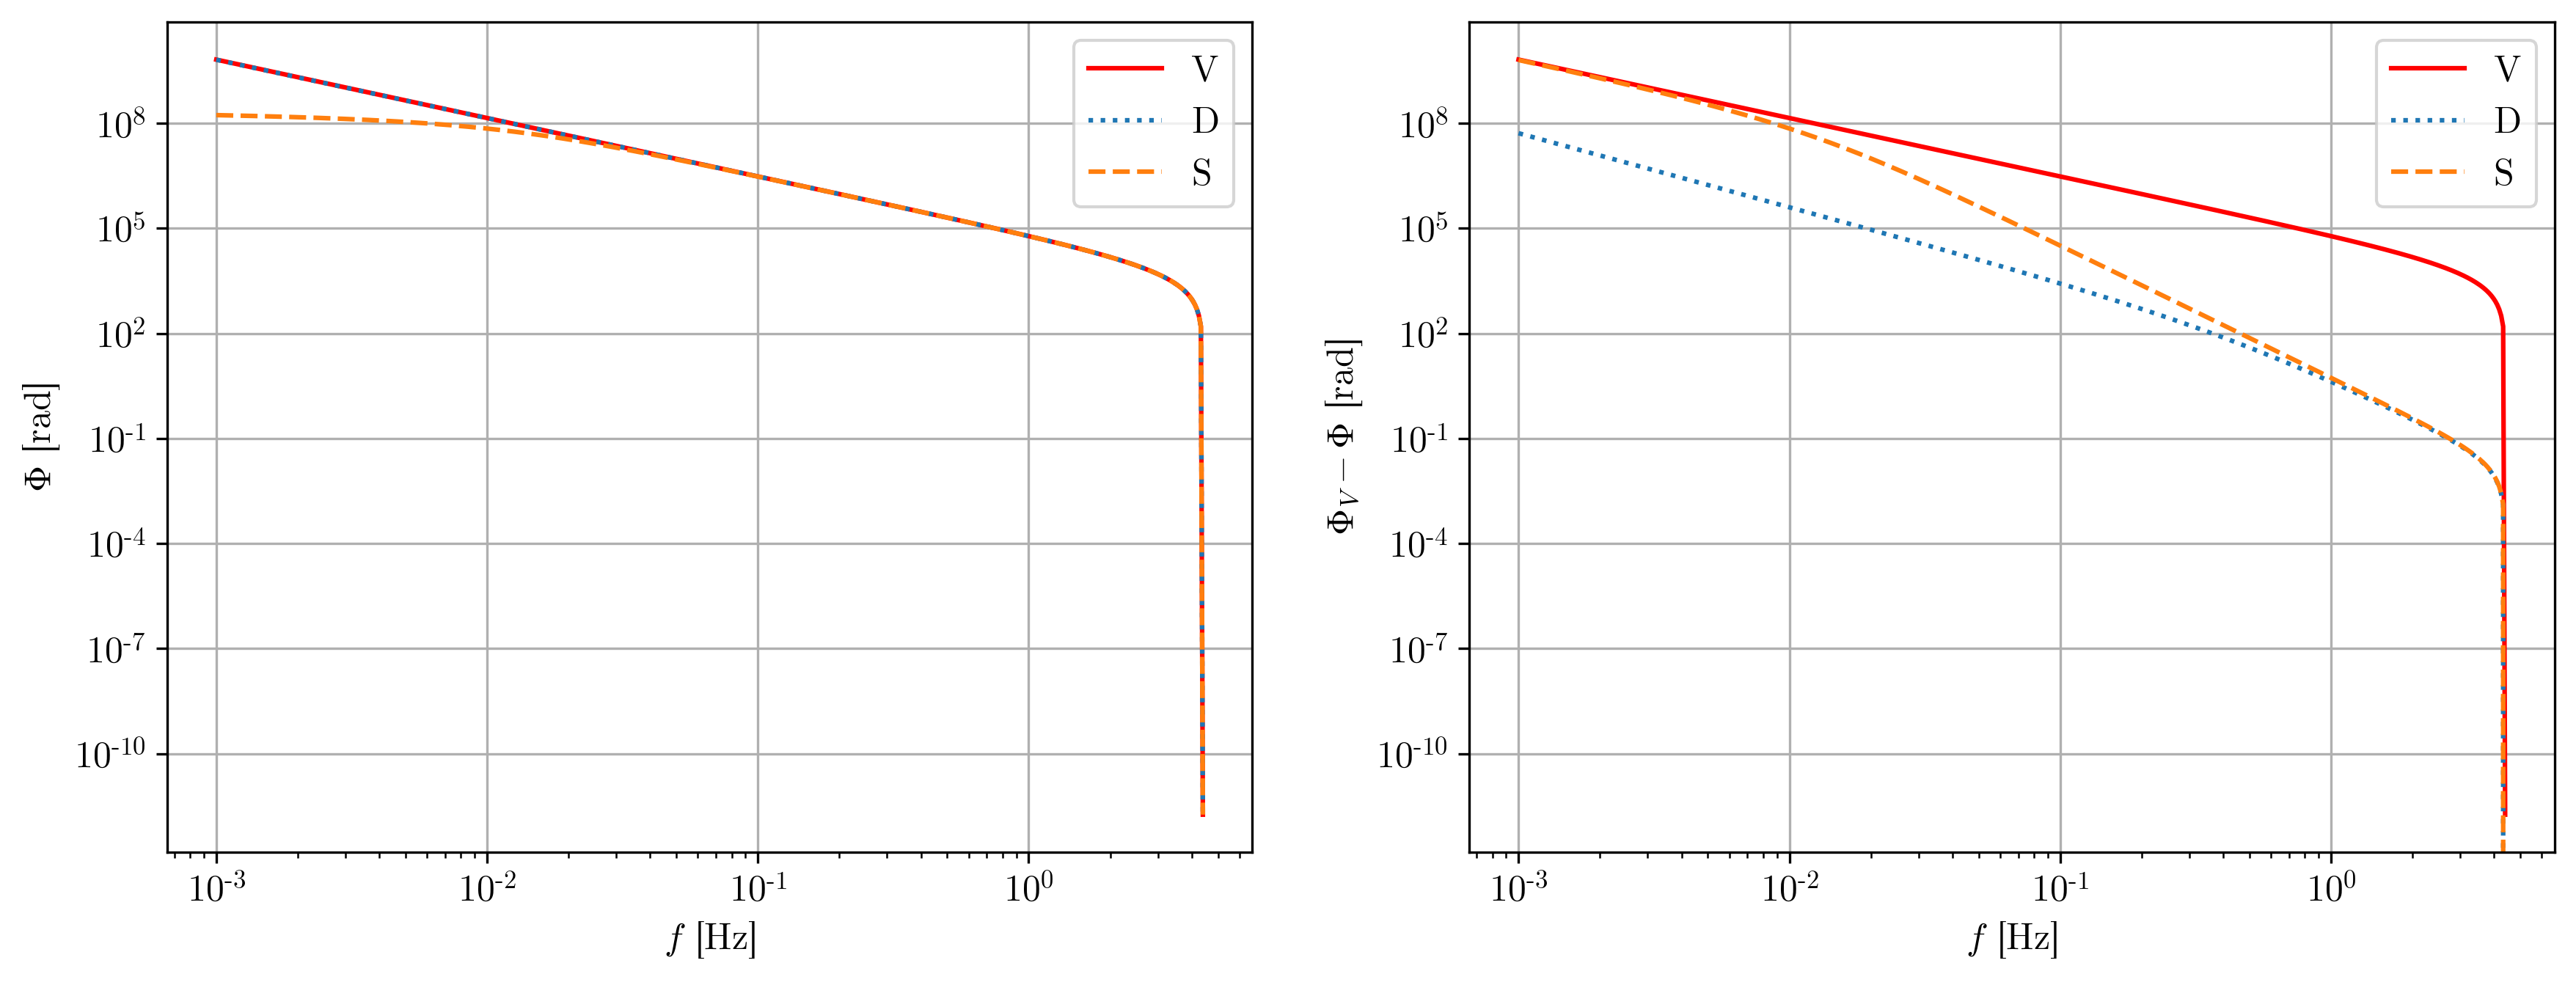

In [3]:
f = jnp.geomspace(1e-3, f_c, 500)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.loglog(f, Phi_to_c(f, f_c, vb, "v"), "r", label="V")
ax.loglog(f, Phi_to_c(f, f_c, dd, "d"), ":", label="D")
ax.loglog(f, Phi_to_c(f, f_c, sd, "s"), "--", label="S")
ax.legend()
ax.grid()
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\Phi$ [rad]")

ax = axes[1]
ax.loglog(f, Phi_to_c(f, f_c, vb, "v"), "r", label="V")
ax.loglog(f, Phi_to_c(f, f_c, vb, "v") - Phi_to_c(f, f_c, dd, "d"), ":", label="D")
ax.loglog(f, Phi_to_c(f, f_c, vb, "v") - Phi_to_c(f, f_c, sd, "s"), "--", label="S")
ax.legend()
ax.grid()
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\Phi_V - \Phi$ [rad]")

Text(0, 0.5, '$\\Psi_V - \\Psi$ [rad]')

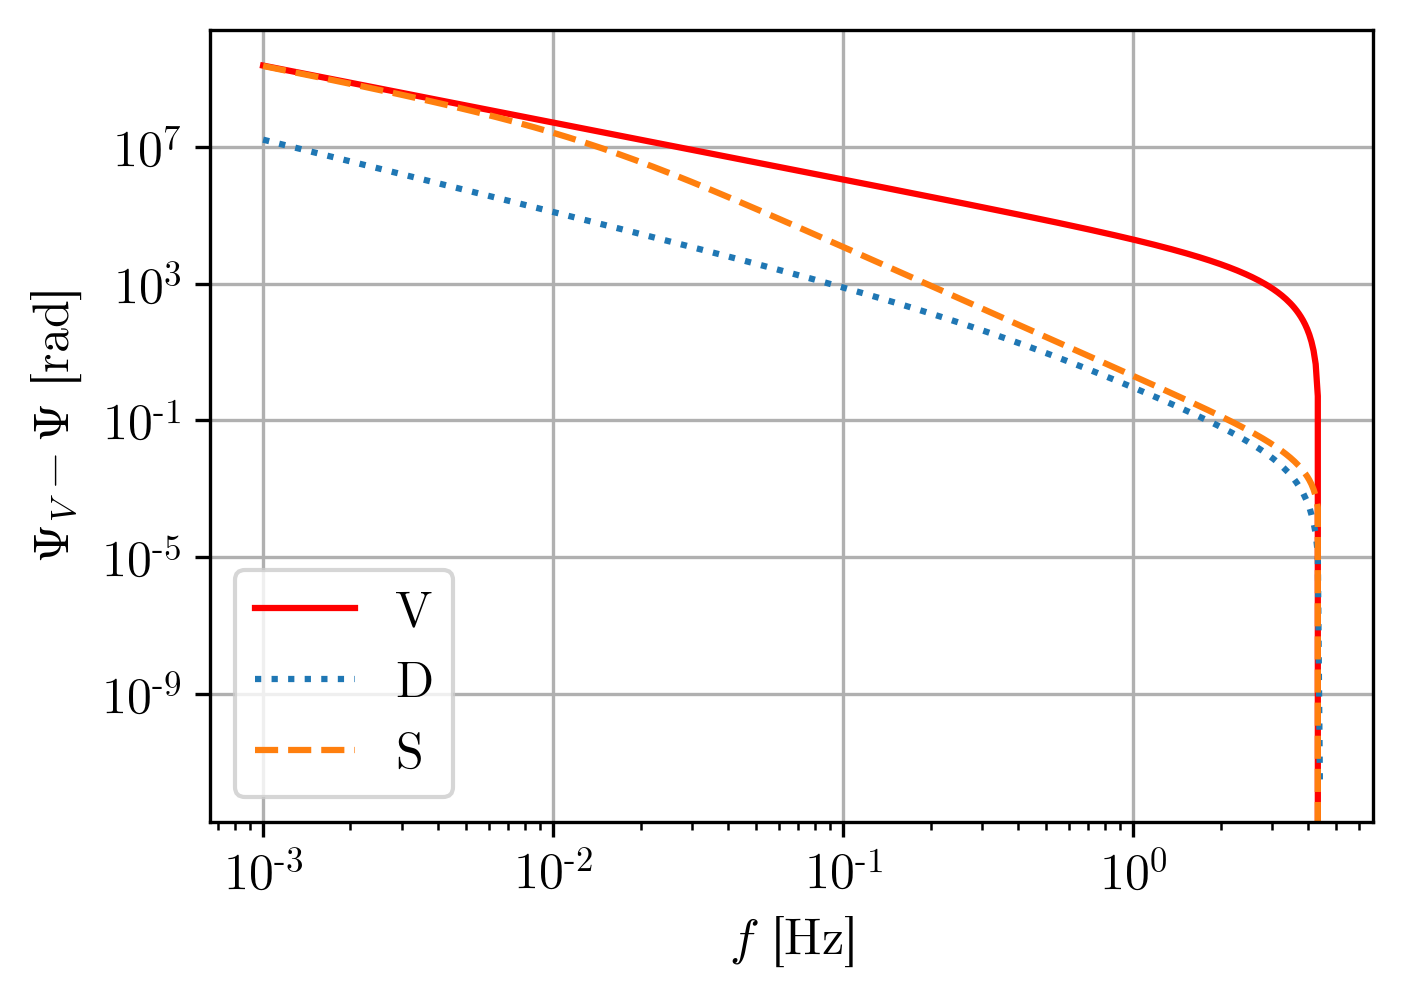

In [39]:
f = jnp.geomspace(1e-3, f_c, 500)
fig, ax = plt.subplots(1, 1)#, figsize=(14, 5))

ax.loglog(f, Psi(f, f_c, vb, "v"), "r", label="V")
ax.loglog(f, Psi(f, f_c, vb, "v") - Psi(f, f_c, dd, "d"), ":", label="D")
ax.loglog(f, Psi(f, f_c, vb, "v") - Psi(f, f_c, sd, "s"), "--", label="S")
ax.legend()
ax.grid()
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\Psi_V - \Psi$ [rad]")

## Likelihood checks

In [5]:
from jax import jit

With scipy:
```
SNR(s) =  9.193779235810998
SNR(h) =  9.196551816697275
log L(s|s) =  42.262788318414735
log L(h|h) =  42.28828265859896
log L(h|s) =  42.08482816097782
```

With jax interpolator, `trapz` and 5000 points:
```
SNR(s) =  9.19376753760959
SNR(h) =  9.196541692746678
log L(s|s) =  42.26268076780195
log L(h|h) =  42.288189553213975
log L(h|s) =  42.08425870908815
```

With jax interpolator, `simps` and 5000 points:
```
SNR(s) =  9.193760960108834
SNR(h) =  9.196536000394095
log L(s|s) =  42.262620295810656
log L(h|h) =  42.28813720327233
log L(h|s) =  42.084231124778
```

With jax interpolator, `simps` and 3000 points:
```
SNR(s) =  9.193760960111337
SNR(h) =  9.196536000395968
log L(s|s) =  42.26262029583365
log L(h|h) =  42.288137203289544
log L(h|s) =  42.08419191768377
```
Seems good enough.

In [46]:
test_SNR_loglikelihood()

SNR(s) =  9.193760960111337
SNR(h) =  9.196536000395968
log L(s|s) =  42.26262029583365
log L(h|h) =  42.288137203289544
log L(h|s) =  42.08419191768377


In [47]:
calculate_SNR_jit = jit(calculate_SNR, static_argnums=(2, 5))
loglikelihood_jit = jit(loglikelihood, static_argnums=(2, 5, 8, 9))

In [48]:
dd_s = DynamicDress(
    jnp.array(2.3333333333333335),
    jnp.array(0.00018806659428775589),
    jnp.array(3.151009407916561e31),
    jnp.array(0.001),
    jnp.array(0.0),
    jnp.array(0.0),
    jnp.array(-56.3888135025341),
)

dd_h = DynamicDress(
    jnp.array(2.2622788817665738),
    jnp.array(4.921717647731646e-5),
    jnp.array(3.151580260164573e31),
    jnp.array(0.0005415094825728555),
    jnp.array(dd_s.Phi_c),
    jnp.array(-227.74995698),
    jnp.array(dd_s.dL_iota),
)
f_c = get_f_isco(get_m_1(dd_s.M_chirp, dd_s.q))
f_l = jnp.array(0.022621092492458004)  # Hz
f_c_h = get_f_isco(get_m_1(dd_h.M_chirp, dd_h.q))

# Compile the functions
loglikelihood_jit(dd_s, f_c, "d", dd_s, f_c, "d", f_l, f_c, 5000, 5000)
calculate_SNR_jit(dd_s, f_c, "d", f_l, f_c, 3000)

DeviceArray(9.19377924, dtype=float64)

In [49]:
%timeit calculate_SNR_jit(dd_s, f_c, "d", f_l, f_c, 500)

111 µs ± 2.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [50]:
%timeit calculate_SNR_jit(dd_h, f_c_h, "d", f_l, f_c, 3000)

265 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [52]:
%%timeit
loglikelihood_jit(dd_s, f_c, "d", dd_s, f_c, "d", f_l, f_c, 3000, 3000)
loglikelihood_jit(dd_h, f_c_h, "d", dd_h, f_c_h, "d", f_l, f_c_h, 3000, 3000)
loglikelihood_jit(dd_h, f_c_h, "d", dd_s, f_c, "d", f_l, f_c, 3000, 3000)

7.24 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## SVI

In [2]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoMultivariateNormal
from numpyro.infer.initialization import init_to_value

In [3]:
m_1 = jnp.array(1e3 * MSUN)
m_2 = jnp.array(1 * MSUN)
rho_s = jnp.array(226 * MSUN / PC**3)
gamma_s = jnp.array(7 / 3)
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)
dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)

r_gamma_s = 2e-4# 1e-1  # 4D
dist_gamma_s = dist.Uniform(
    dd_s.gamma_s * (1 - r_gamma_s), dd_s.gamma_s * (1 + r_gamma_s)
)
r_c_f = 2e-1  # 4D
dist_c_f = dist.Uniform(
    dd_s.c_f * (1 - r_c_f), dd_s.c_f * (1 + r_c_f)
)
r_M_chirp_MSUN = 2e-5 # 1e-4  # 4D
dist_M_chirp_MSUN = dist.Uniform(
    dd_s.M_chirp / MSUN * (1 - r_M_chirp_MSUN),
    dd_s.M_chirp / MSUN * (1 + r_M_chirp_MSUN)
)
d_tT_c = 15  # 120  # 4D
dist_tT_c = dist.Uniform(-d_tT_c, d_tT_c)

@jax.jit
def logL_svi(dd_h):
    f_c_h = get_f_isco(get_m_1(dd_h.M_chirp, dd_h.q))
    return loglikelihood(dd_h, f_c_h, "d", dd_s, f_c, "d", f_l, f_c)

def model():
    gamma_s = numpyro.sample("gamma_s", dist_gamma_s)
    # c_f = numpyro.sample("c_f", dist_c_f)
    c_f = dd_s.c_f
    M_chirp_MSUN = numpyro.sample("M_chirp_MSUN", dist_M_chirp_MSUN)
    q = dd_s.q
    Phi_c = dd_s.Phi_c
    tT_c = numpyro.sample("tT_c", dist_tT_c)
    dL_iota = dd_s.dL_iota
    dd_h = DynamicDress(
        gamma_s,
        c_f,
        M_chirp_MSUN * MSUN,
        q,
        Phi_c,
        tT_c,
        dL_iota
    )
    numpyro.factor("logL(h|s)", logL_svi(dd_h))

In [ ]:
print(logL_svi(dd_s))
print(logL_svi(dd_s))

Delta guide

In [21]:
guide_delta = AutoDelta(model)
optimizer = numpyro.optim.Adam(step_size=1e-3)
svi_delta = SVI(model, guide_delta, optimizer, loss=Trace_ELBO())
svi_delta_result = svi_delta.run(random.PRNGKey(50), 2000)
params_delta = svi_delta_result.params

100%|██████████| 2000/2000 [04:20<00:00,  7.69it/s, init loss: -11.5140, avg. loss [1901-2000]: -53.2009] 


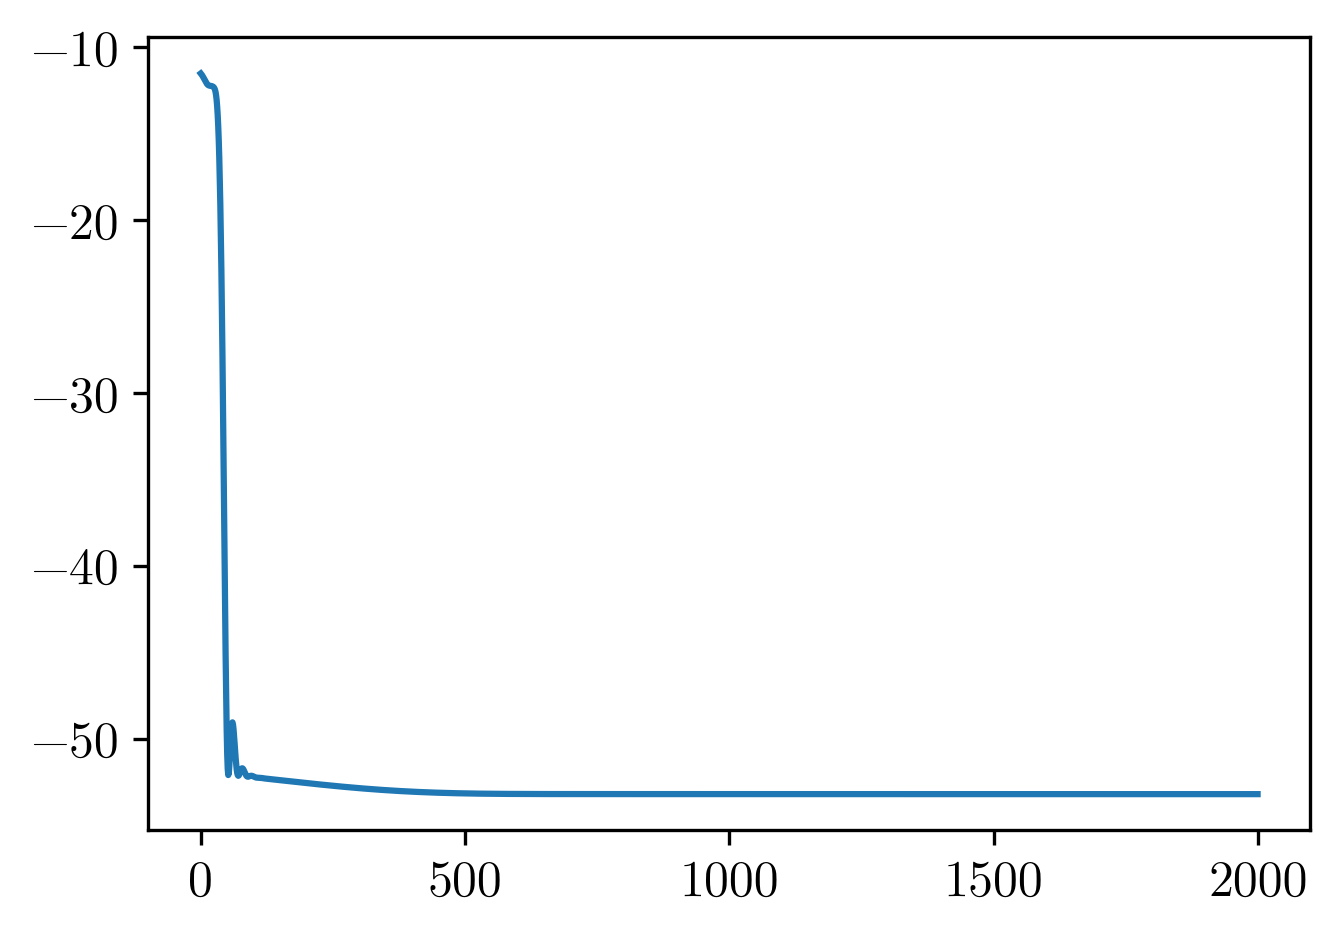

In [38]:
plt.plot(svi_delta_result.losses)

In [39]:
params_delta

{'M_chirp_MSUN_auto_loc': DeviceArray(15.8457642, dtype=float64),
 'gamma_s_auto_loc': DeviceArray(2.33333825, dtype=float64),
 'tT_c_auto_loc': DeviceArray(-0.05837404, dtype=float64)}

MVN guide

In [ ]:
params_delta = {
    'M_chirp_MSUN_auto_loc': jnp.array(15.8457642),
    'gamma_s_auto_loc': jnp.array(2.33333825),
    'tT_c_auto_loc': jnp.array(-0.05837404)
}
init_loc = {k.split("_auto_loc")[0]: v for k, v in params_delta.items()}

In [ ]:
init_loc

In [ ]:
guide_mvn = AutoMultivariateNormal(
    model, init_loc_fn=init_to_value(values=params_delta), init_scale=1e-4
)
optimizer = numpyro.optim.Adam(step_size=1e-3)
svi_mvn = SVI(model, guide_mvn, optimizer, loss=Trace_ELBO())
svi_mvn_result = svi_mvn.run(random.PRNGKey(83), 4000)
params_mvn = svi_mvn_result.params

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
import os
os.system('say SVI complete')

In [179]:
r_gamma_s = 1e-1
r_c_f = 2e-1
r_M_chirp_MSUN = 1e-4
d_tT_c = 120

labels = (
    r"$\gamma_s$",
    r"$c_f$ [?]",
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\tilde{t}_c$ [s]"
)

def ptform(u):
    return jnp.array([
        dd_s.gamma_s * (1 + r_gamma_s * (2 * u[0] - 1)),
        dd_s.c_f * (1 + r_c_f * (2 * u[1] - 1)),
        dd_s.M_chirp / MSUN * (1 + r_M_chirp_MSUN * (2 * u[2] - 1)),
        d_tT_c * (2 * u[3] - 1)
    ])

## Nested sampling

### jaxns

In [4]:
from jaxns.nested_sampling import NestedSampler, save_results, load_results
from jaxns.prior_transforms import UniformPrior, PriorChain
from jaxns.plotting import plot_diagnostics, plot_cornerplot
from jaxns.utils import summary, resample

#### Vacuum system

In [185]:
m_1 = 1e3 * MSUN
m_2 = 1 * MSUN
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)
vb_s = make_vacuum_binary(m_1, m_2)

def logL(M_chirp, tT_c, **kwargs):
    vb_h = VacuumBinary(M_chirp, vb_s.Phi_c, tT_c, dL_iota=vb_s.dL_iota)
    return loglikelihood(vb_h, f_c, "v", vb_s, f_c, "v", f_l, f_c)

prior_M_chirp = UniformPrior(
    'M_chirp', vb_s.M_chirp * (1 - 2e-7), vb_s.M_chirp * (1 + 2e-7)
)
prior_tT_c = UniformPrior('tT_c', -10., 10.)
prior_chain = PriorChain().push(prior_M_chirp).push(prior_tT_c)

ns = NestedSampler(
    loglikelihood=logL,
    prior_chain=prior_chain,
    sampler_name='slice',
#     num_parallel_samplers=1,
#     sampler_kwargs=dict(depth=5, num_slices=prior_chain.U_ndims*5),
    num_live_points=300,
    max_samples=1e4,
    collect_samples=True,
    collect_diagnostics=True
)
results = jax.jit(ns)(random.PRNGKey(17345), termination_frac=0.001)

summary(results)

ESS=1355.5791707866344
--------
M_chirp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | max(L) est.
M_chirp: 3.1510094e+31 +- 1e+24 | 3.1510093e+31 / 3.1510093e+31 / 3.1510095e+31 | 3.1510094e+31
--------
tT_c: mean +- std.dev. | 10%ile / 50%ile / 90%ile | max(L) est.
tT_c: -0.0 +- 3.0 | -3.0 / -0.0 / 3.0 | -0.0
--------


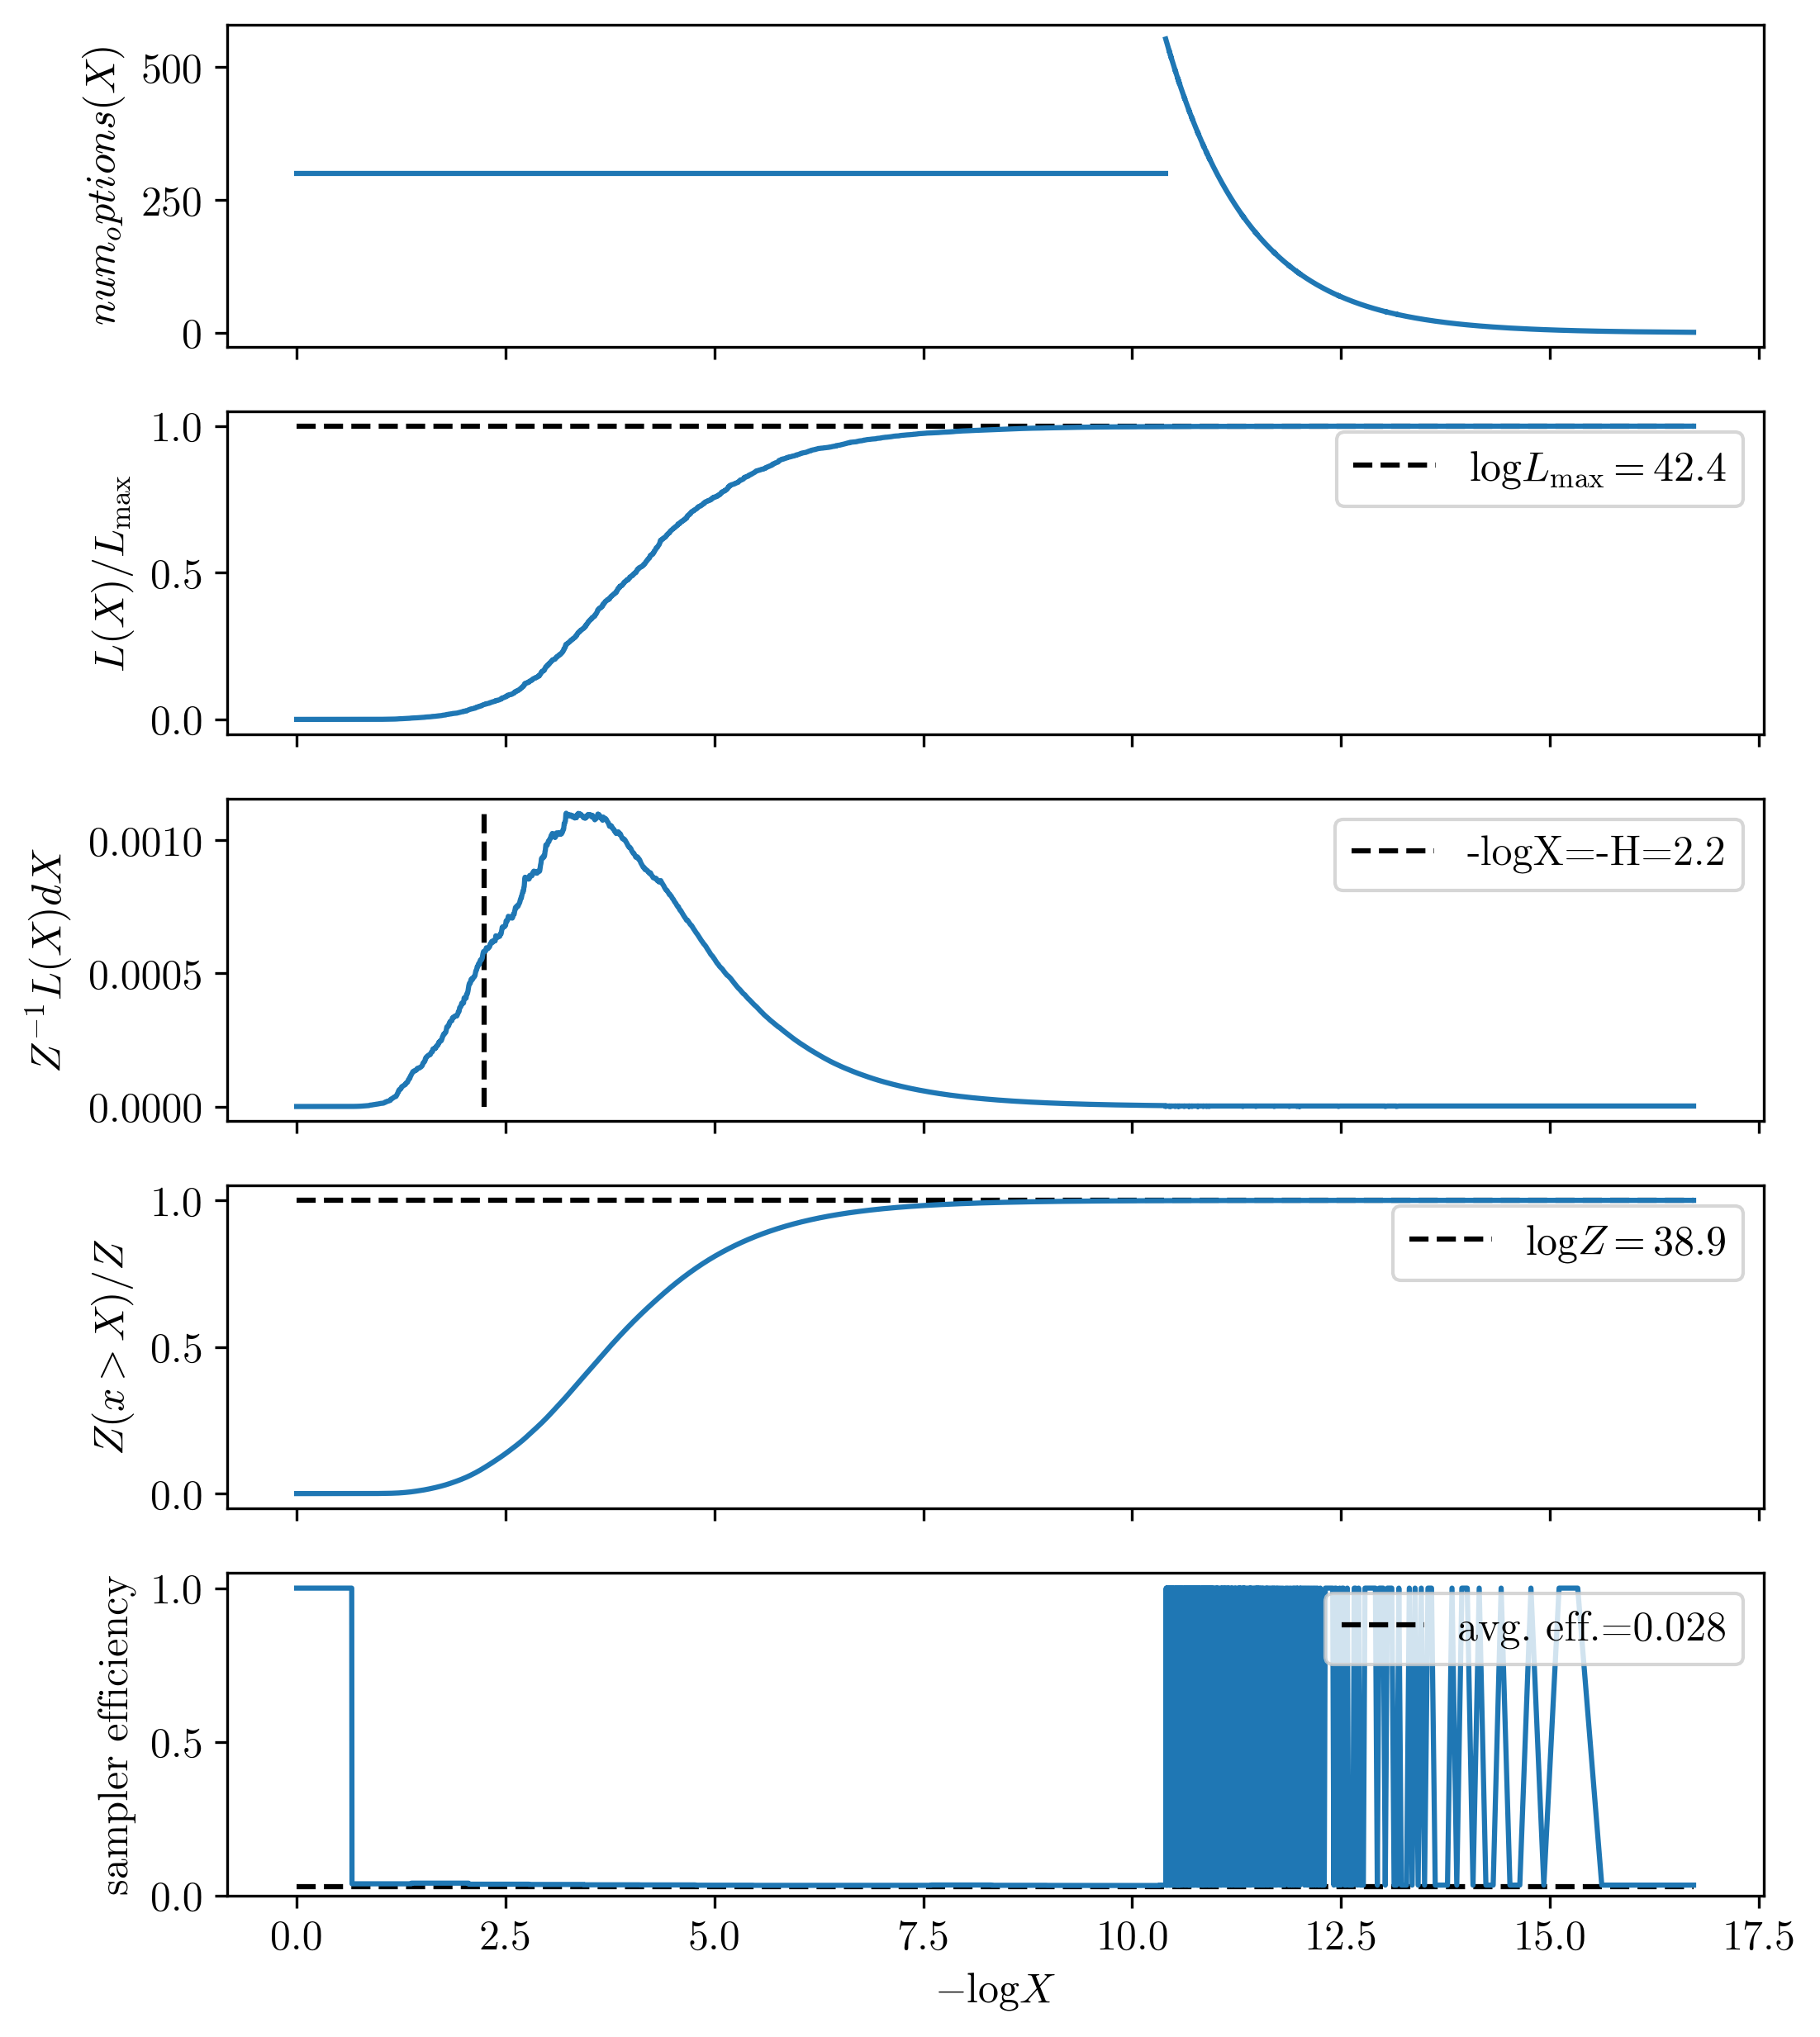

In [186]:
plot_diagnostics(results)

Text(0.5, 0, '$\\tilde{t}_c$ [s]')

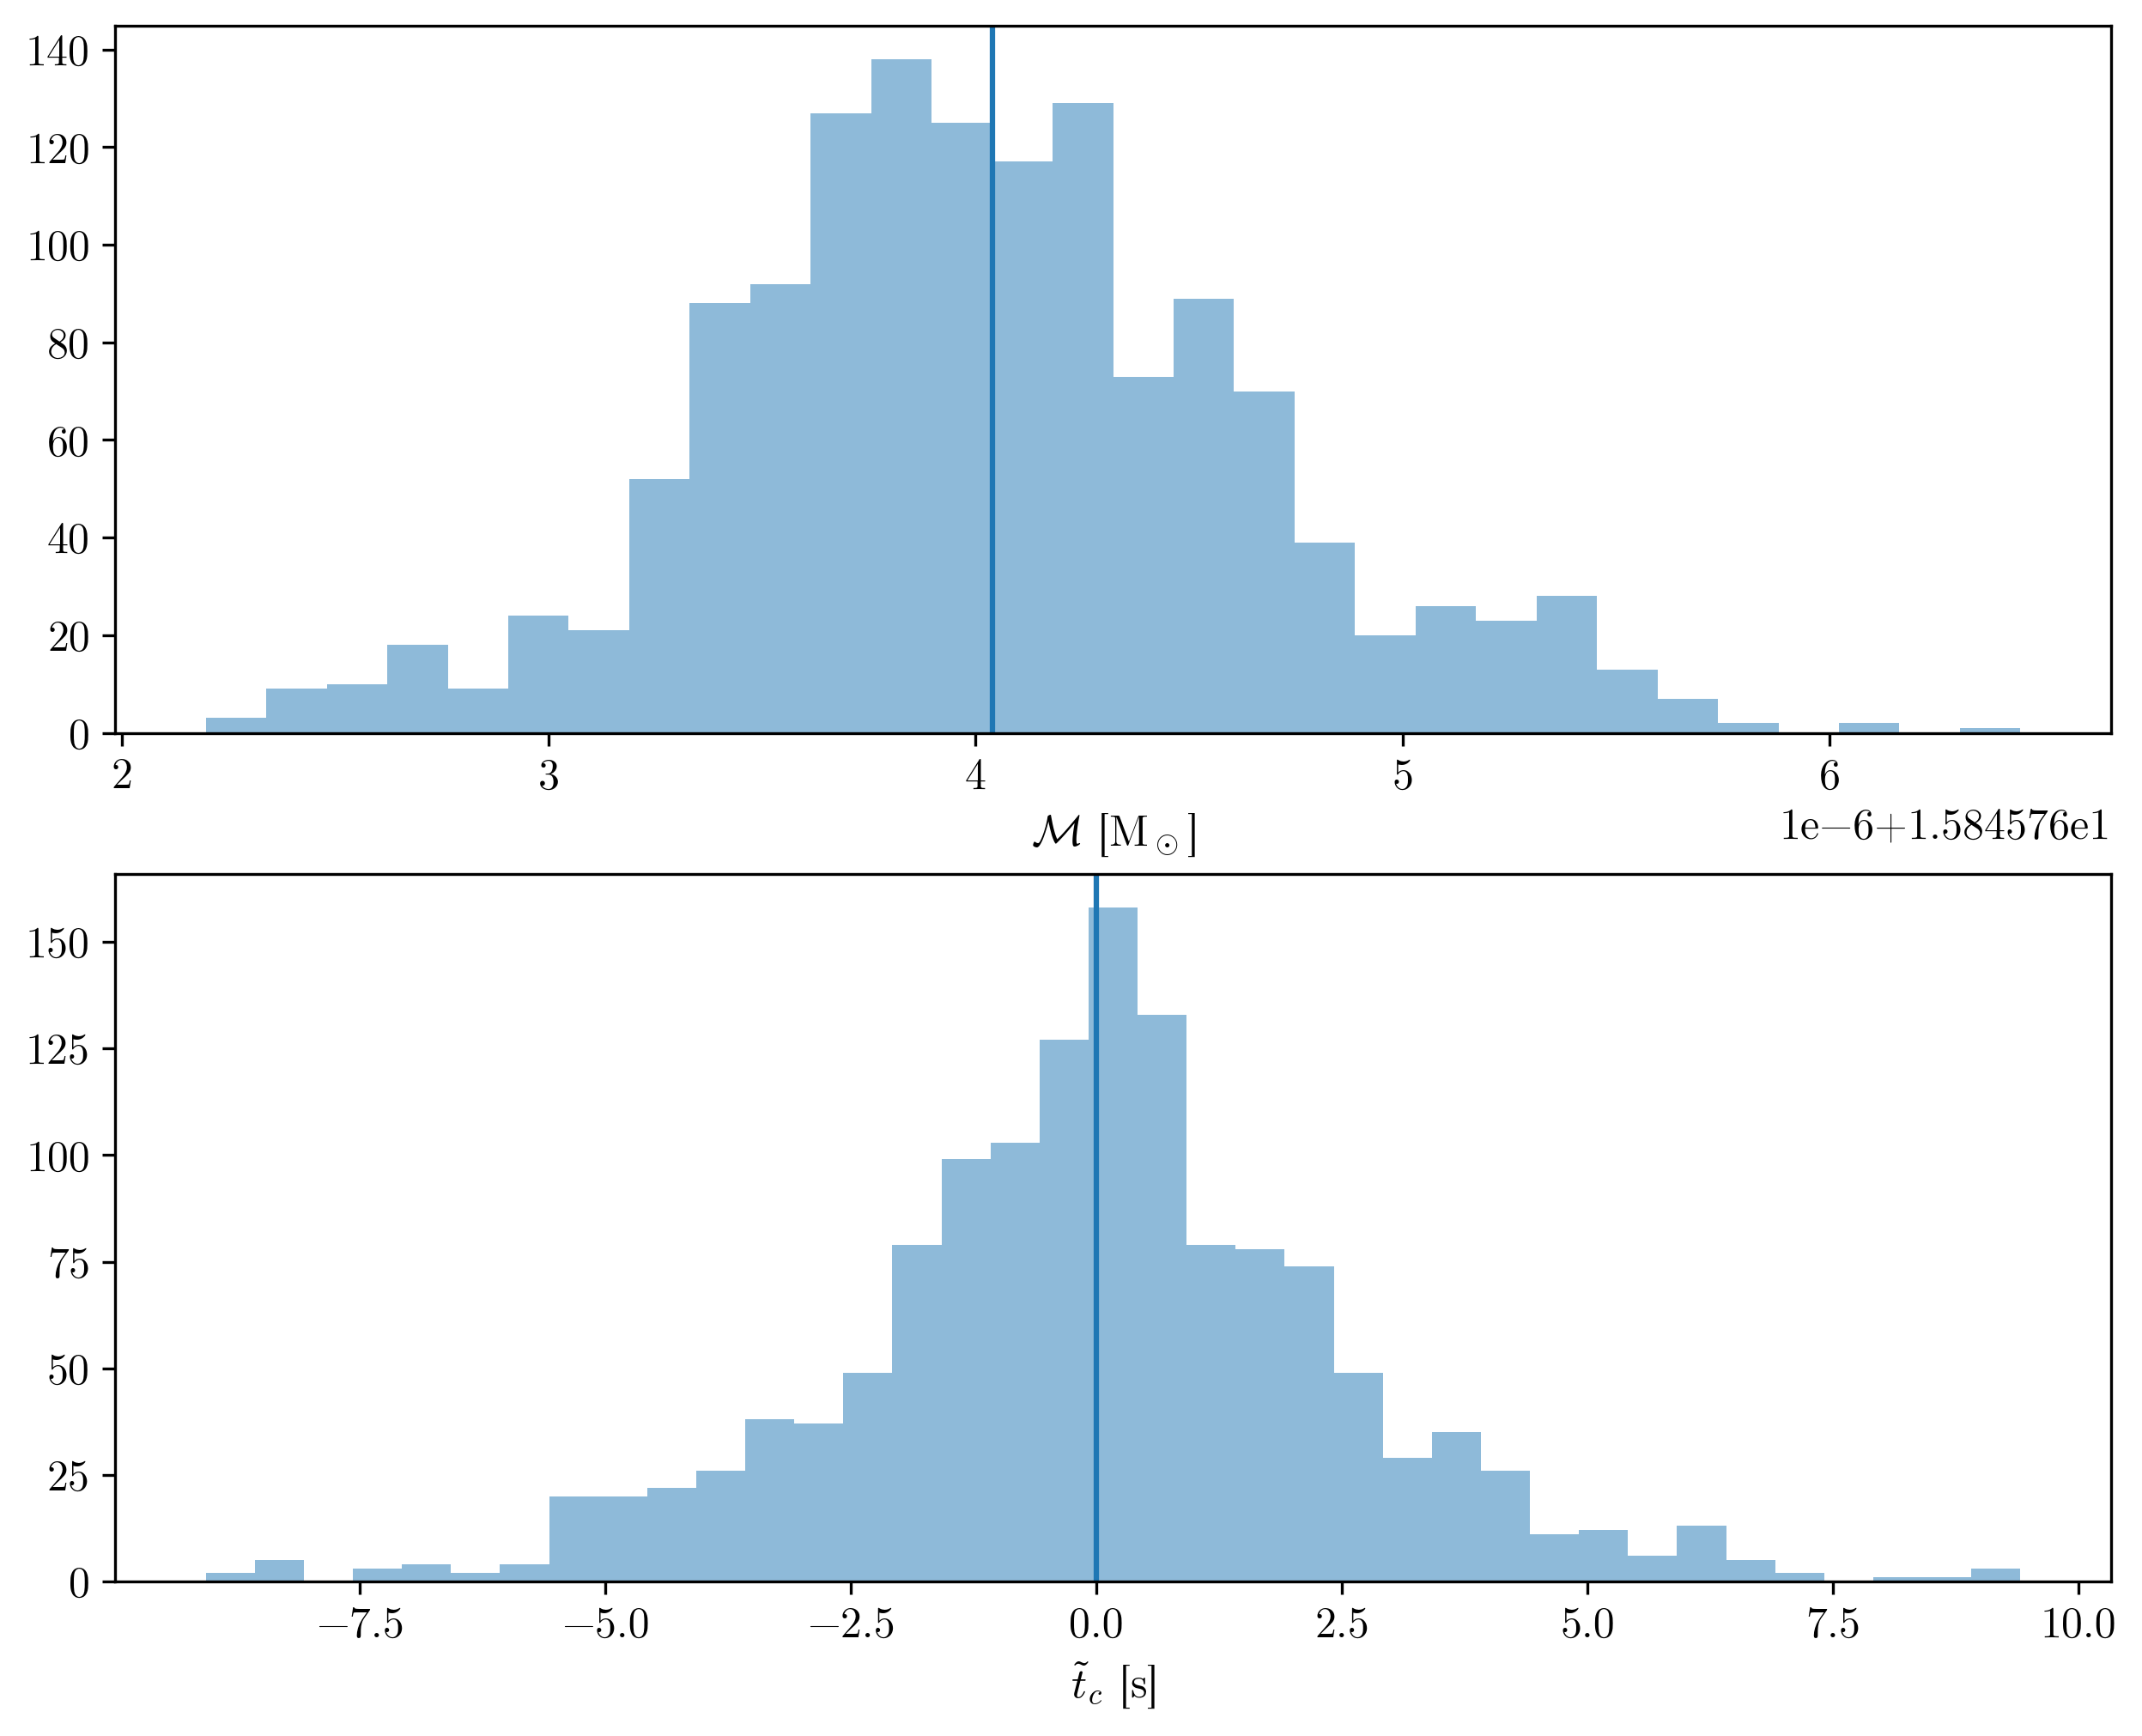

In [187]:
# plot_cornerplot(results)

samples = resample(random.PRNGKey(45),results.samples, results.log_p, S=int(results.ESS))

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

ax = axes[0]
ax.hist(samples['M_chirp'] / MSUN, bins='auto', alpha=0.5)
ax.axvline(vb_s.M_chirp / MSUN)
ax.set_xlabel(r"$\mathcal{M}$ [M$_\odot$]")

ax = axes[1]
ax.hist(samples['tT_c'], bins='auto', alpha=0.5)
ax.axvline(vb_s.tT_c)
ax.set_xlabel(r"$\tilde{t}_c$ [s]")

#### Dynamic system

In [5]:
m_1 = jnp.array(1e3 * MSUN)
m_2 = jnp.array(1 * MSUN)
rho_s = jnp.array(226 * MSUN / PC**3)
gamma_s = jnp.array(7 / 3)
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)
dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)


def logL(M_chirp_MSUN, tT_c, **kwargs):
    dd_h = DynamicDress(
        dd_s.gamma_s,
        dd_s.c_f,
        M_chirp,
        dd_s.q,
        dd_s.Phi_c,
        tT_c,
        dL_iota=dd_s.dL_iota
    )
    f_c_h = get_f_isco(get_m_1(dd_h.M_chirp, dd_h.q))
    return loglikelihood(dd_h, f_c_h, "d", dd_s, f_c, "d", f_l, f_c)


prior_M_chirp = UniformPrior(
    'M_chirp', dd_s.M_chirp * (1 - 2e-7), dd_s.M_chirp * (1 + 2e-7)
)
prior_tT_c = UniformPrior('tT_c', -10., 10.)
prior_chain = PriorChain().push(prior_M_chirp).push(prior_tT_c)

In [ ]:
ns = NestedSampler(
    loglikelihood=logL,
    prior_chain=prior_chain,
    sampler_name='slice',
#     num_parallel_samplers=1,
#     sampler_kwargs=dict(depth=5, num_slices=prior_chain.U_ndims*5),
    num_live_points=300,
    max_samples=1e4,
    collect_samples=True,
    collect_diagnostics=True
)

# @jax.jit
# def run_jaxns(key):
#     return ns(key, termination_frac=0.001)

results = jax.jit(ns)(random.PRNGKey(17345), termination_frac=0.001)

summary(results)

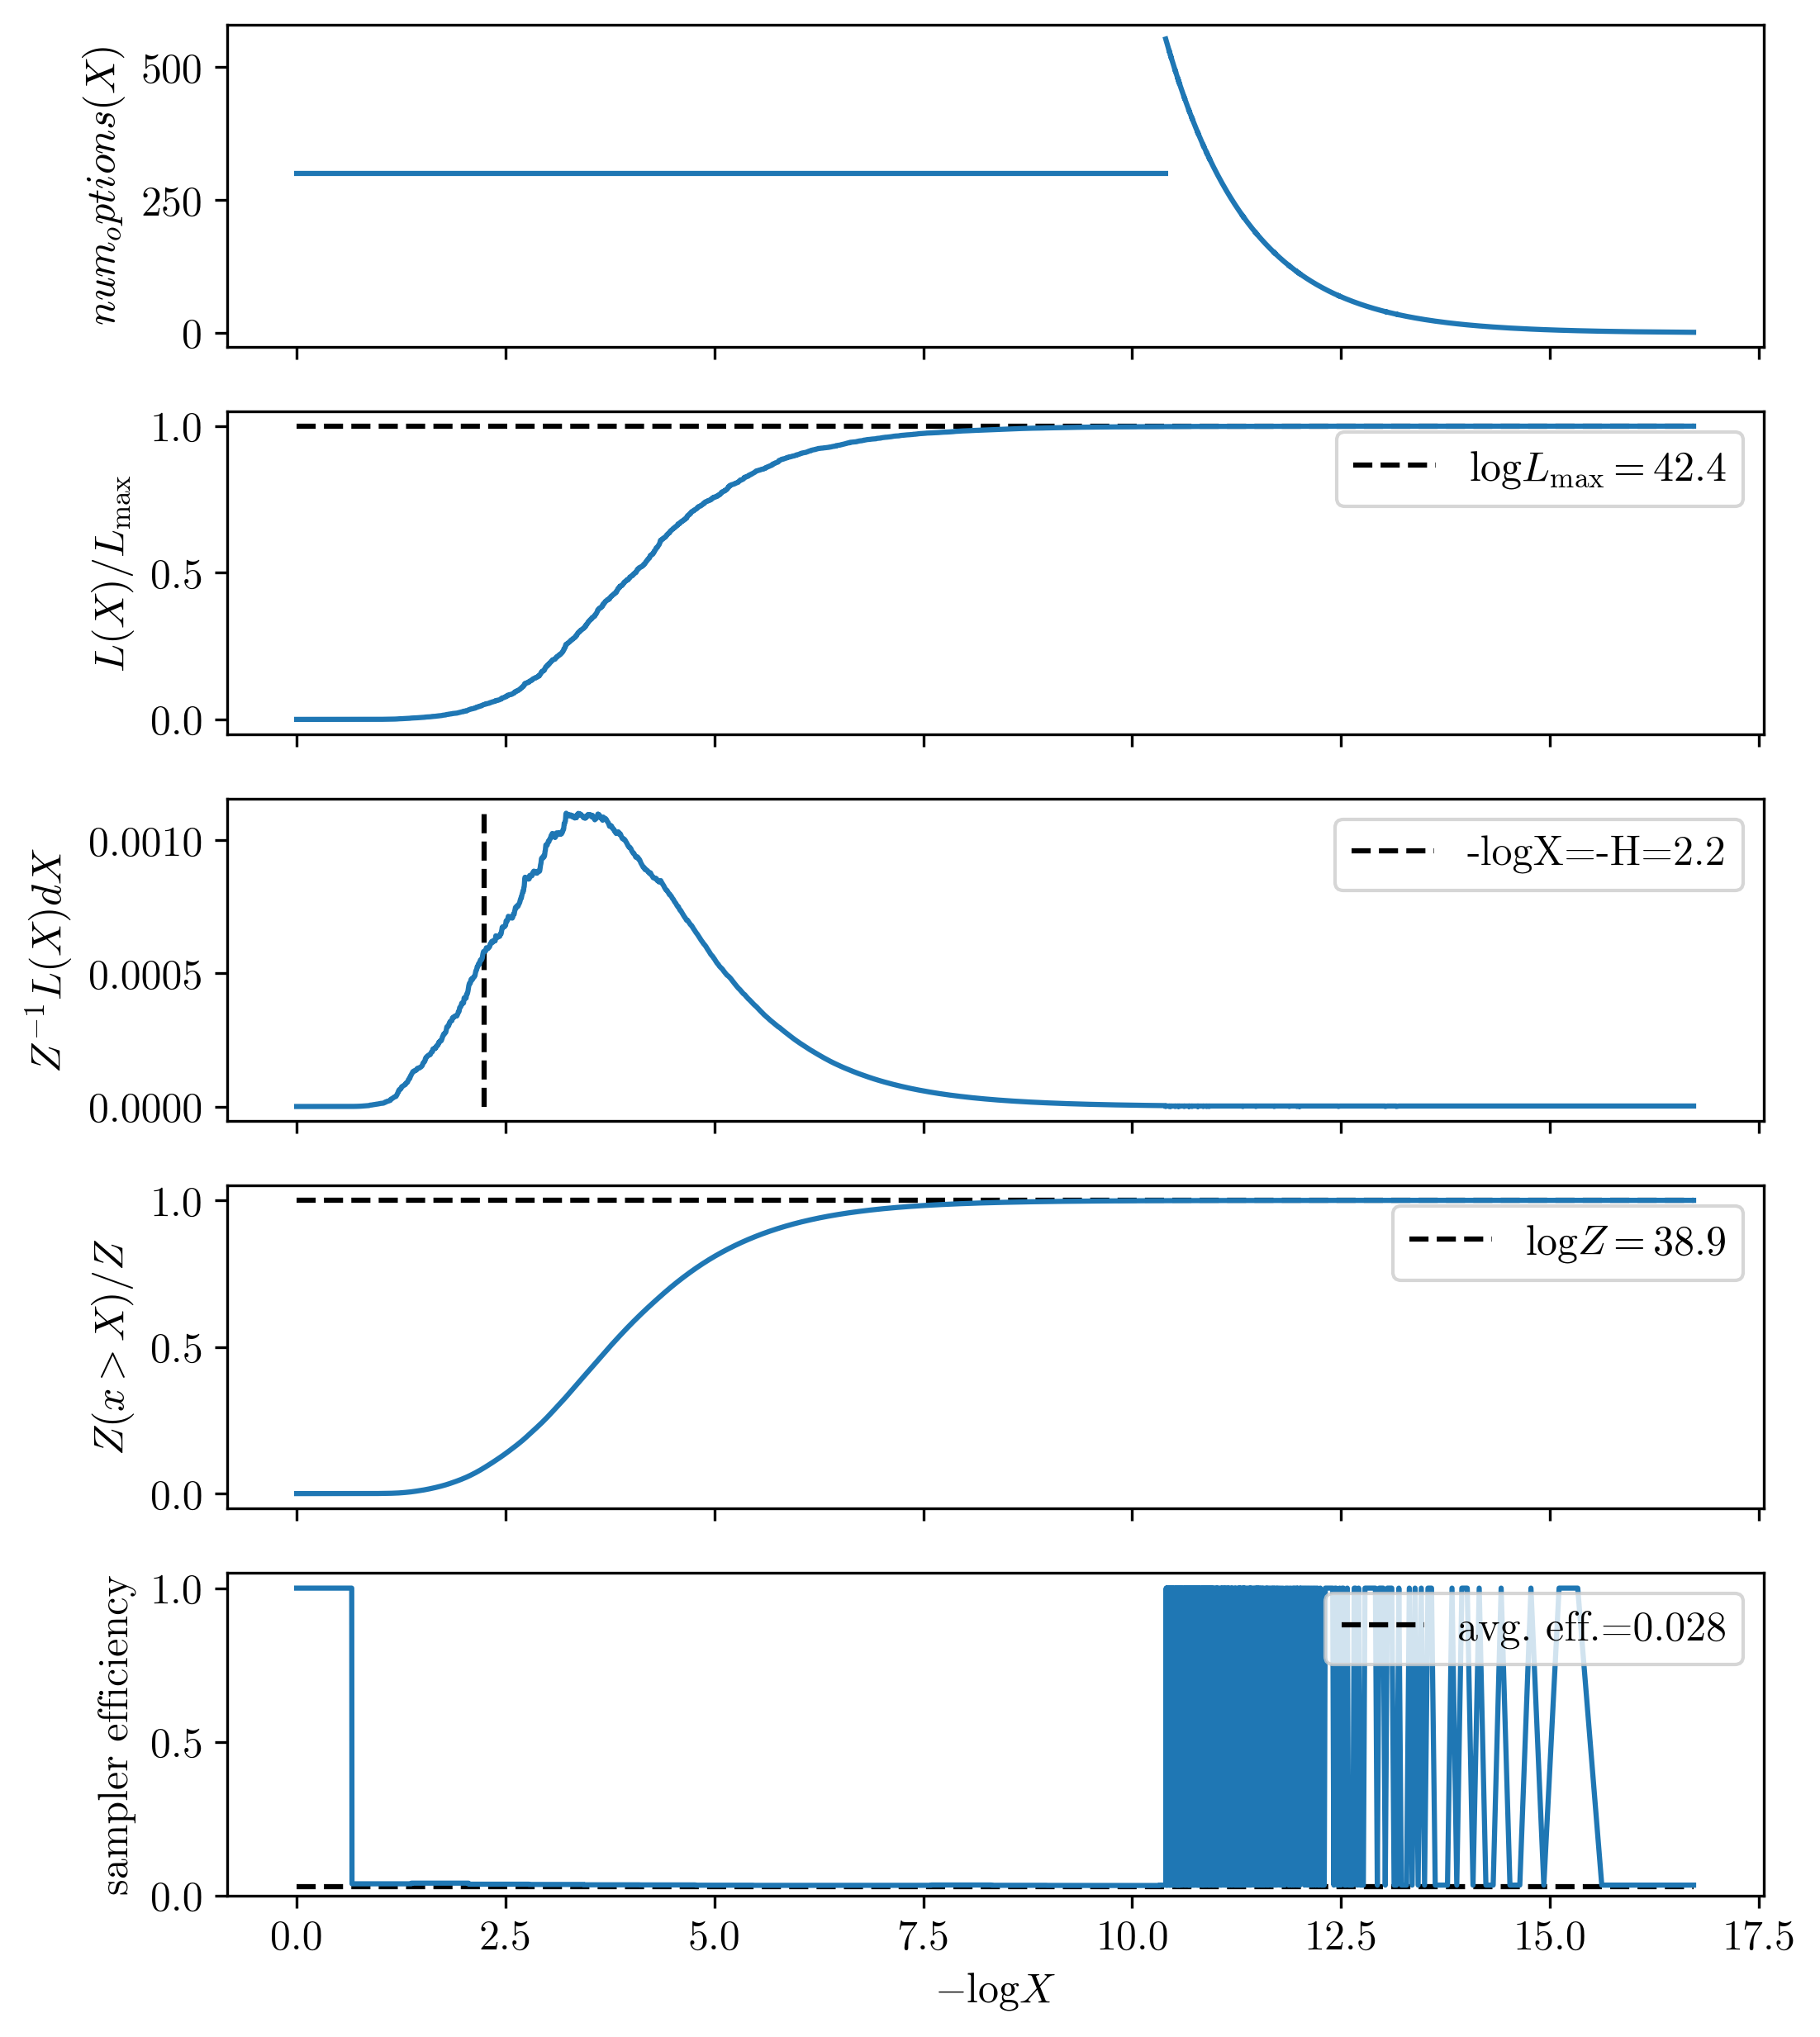

In [186]:
plot_diagnostics(results)

Text(0.5, 0, '$\\tilde{t}_c$ [s]')

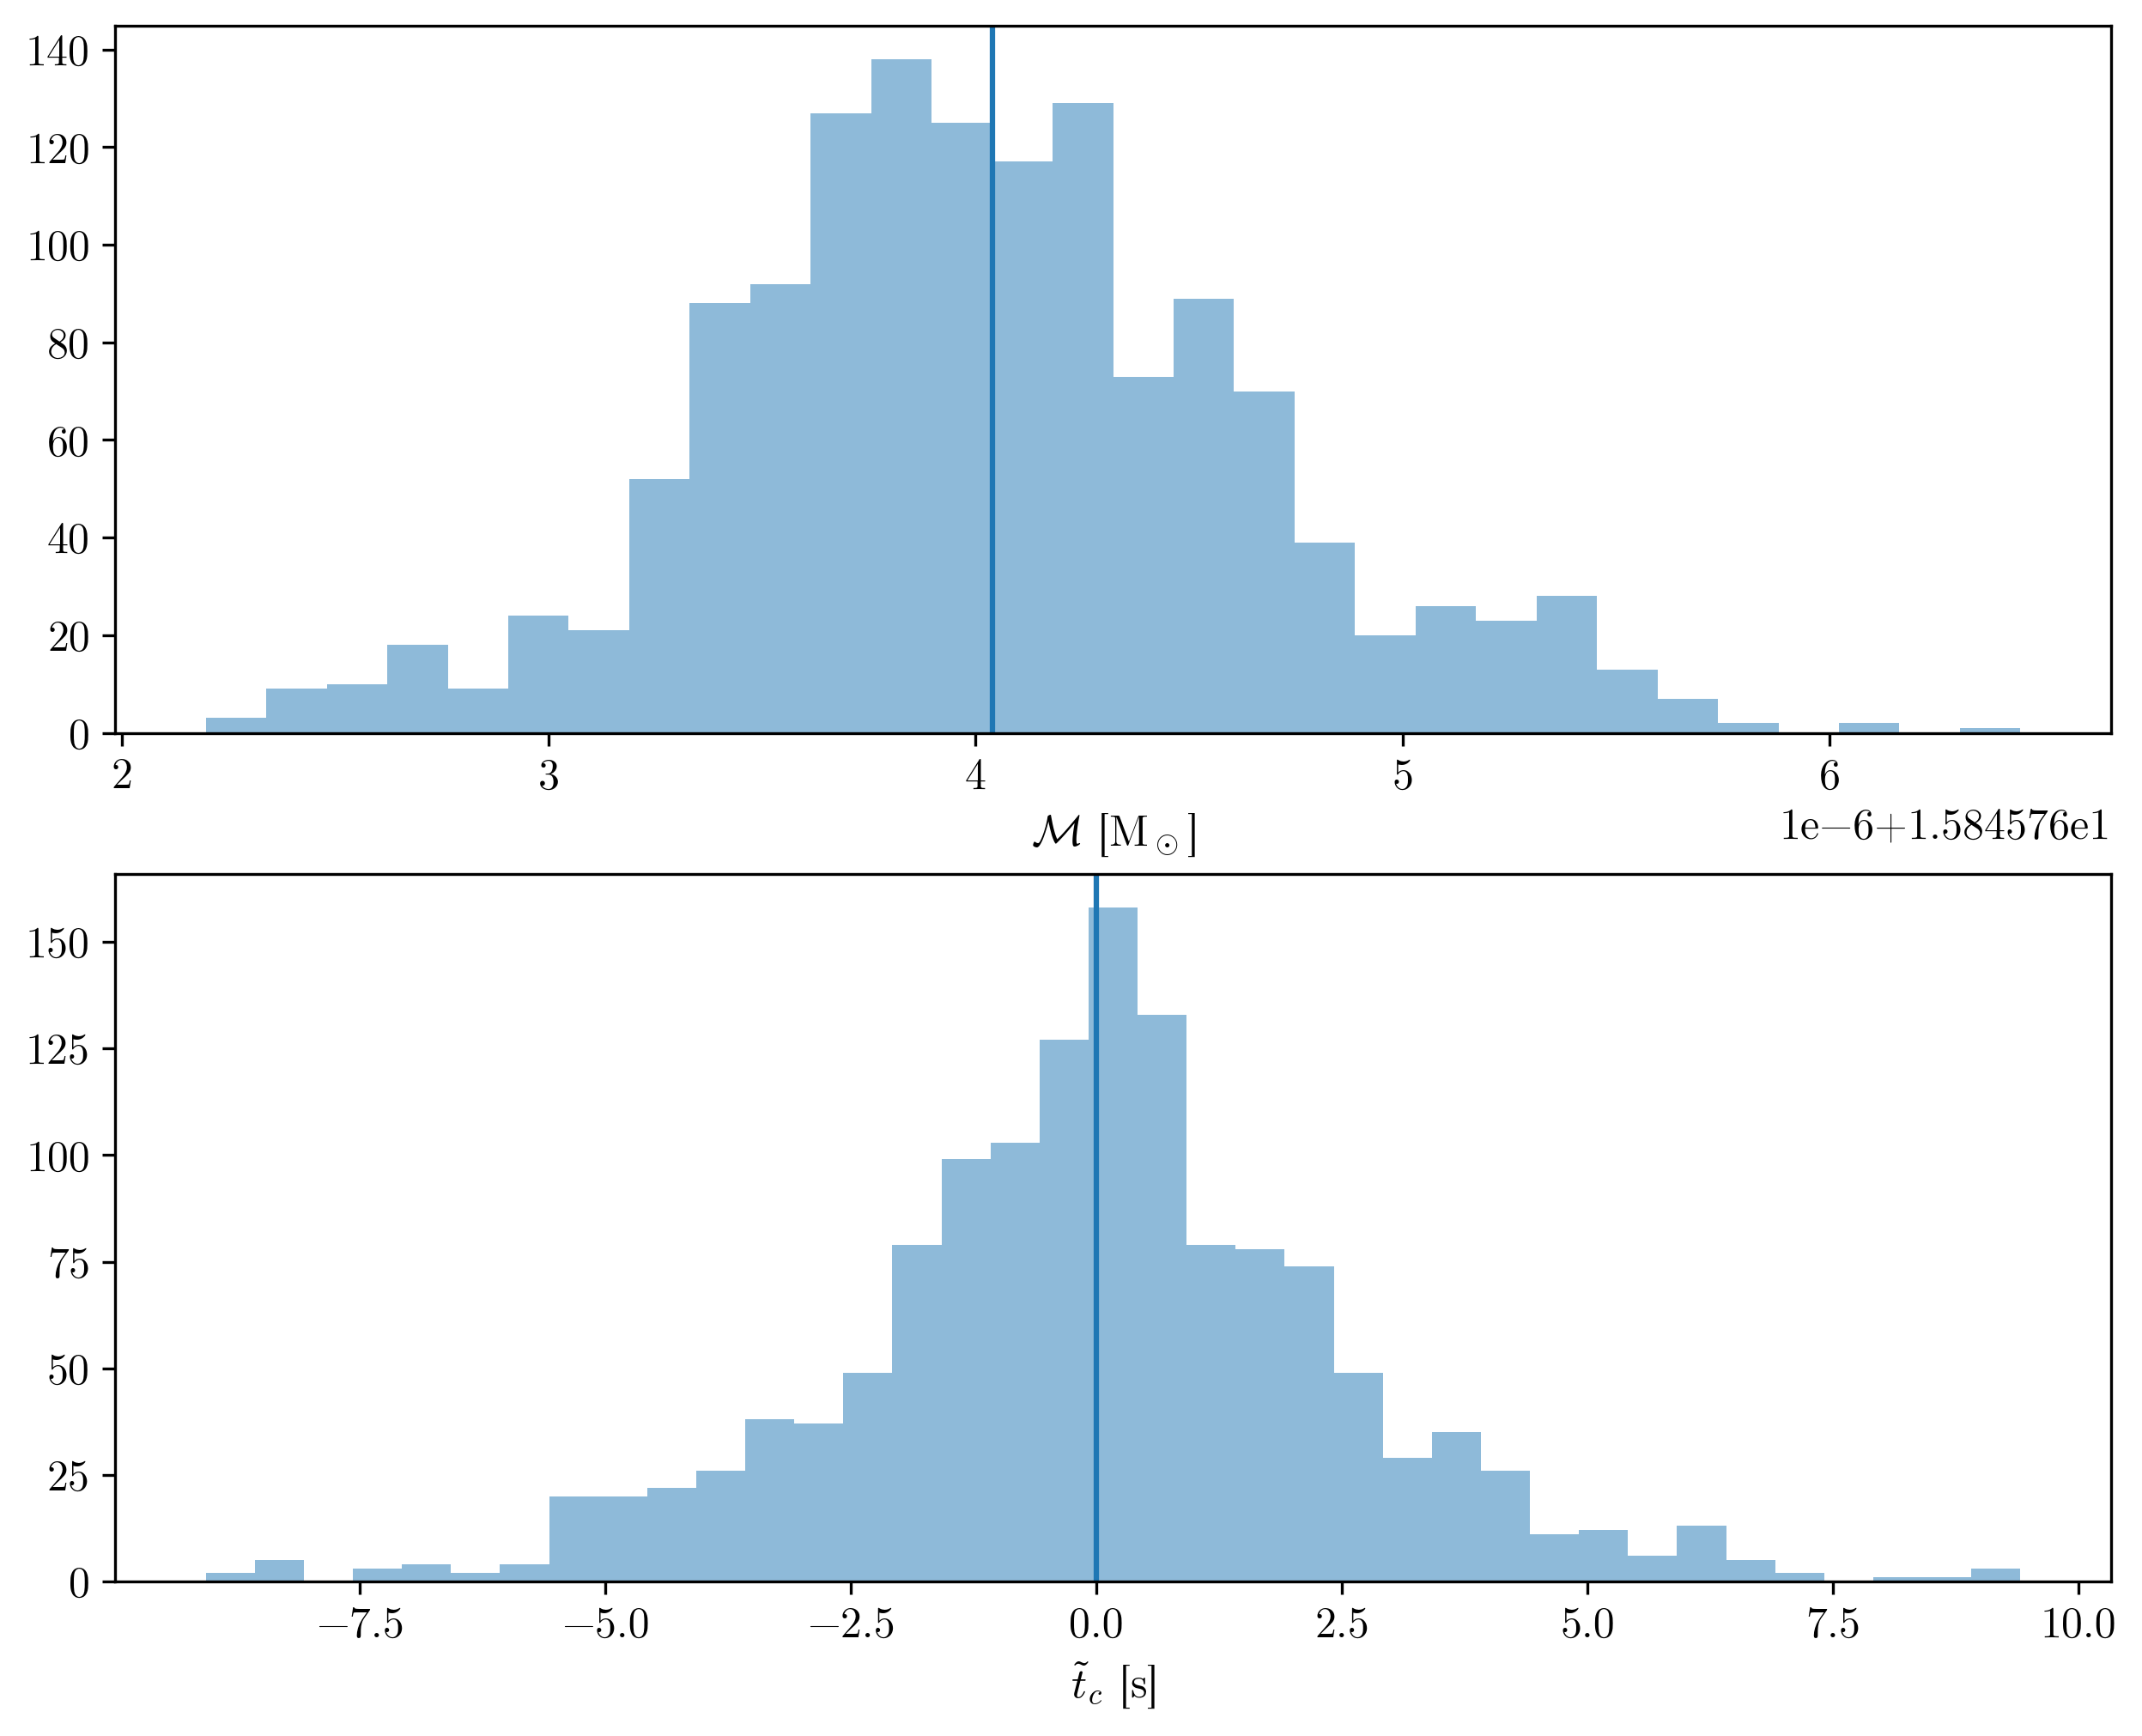

In [187]:
# plot_cornerplot(results)

samples = resample(random.PRNGKey(45),results.samples, results.log_p, S=int(results.ESS))

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

ax = axes[0]
ax.hist(samples['M_chirp'] / MSUN, bins='auto', alpha=0.5)
ax.axvline(vb_s.M_chirp / MSUN)
ax.set_xlabel(r"$\mathcal{M}$ [M$_\odot$]")

ax = axes[1]
ax.hist(samples['tT_c'], bins='auto', alpha=0.5)
ax.axvline(vb_s.tT_c)
ax.set_xlabel(r"$\tilde{t}_c$ [s]")

### dynesty

#### Vacuum system

In [210]:
import dynesty
from dynesty import plotting as dyplot

In [243]:
m_1 = 1e3 * MSUN
m_2 = 1 * MSUN
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)
vb_s = make_vacuum_binary(m_1, m_2)

def ptform(u):
    return jnp.array([
        vb_s.M_chirp / MSUN * (1 + u[0] * 4e-7 - 2e-7),
        u[1] * 20 - 10
    ])

@jax.jit
def logL_dynesty(x):
    M_chirp_MSUN, tT_c = x
    vb_h = VacuumBinary(M_chirp_MSUN * MSUN, vb_s.Phi_c, tT_c, dL_iota=vb_s.dL_iota)
    return _loglikelihood(vb_h, f_c, "v", vb_s, f_c, "v", f_l, f_c)

sampler = dynesty.NestedSampler(logL_dynesty, ptform, 2, nlive=300)
sampler.run_nested()
results = sampler.results

1396it [00:12, 115.68it/s, +300 | bound: 2 | nc: 1 | ncall: 11247 | eff(%): 15.080 | loglstar:   -inf < 42.353 <    inf | logz: 38.989 +/-  0.127 | dlogz:  0.001 >  0.309]


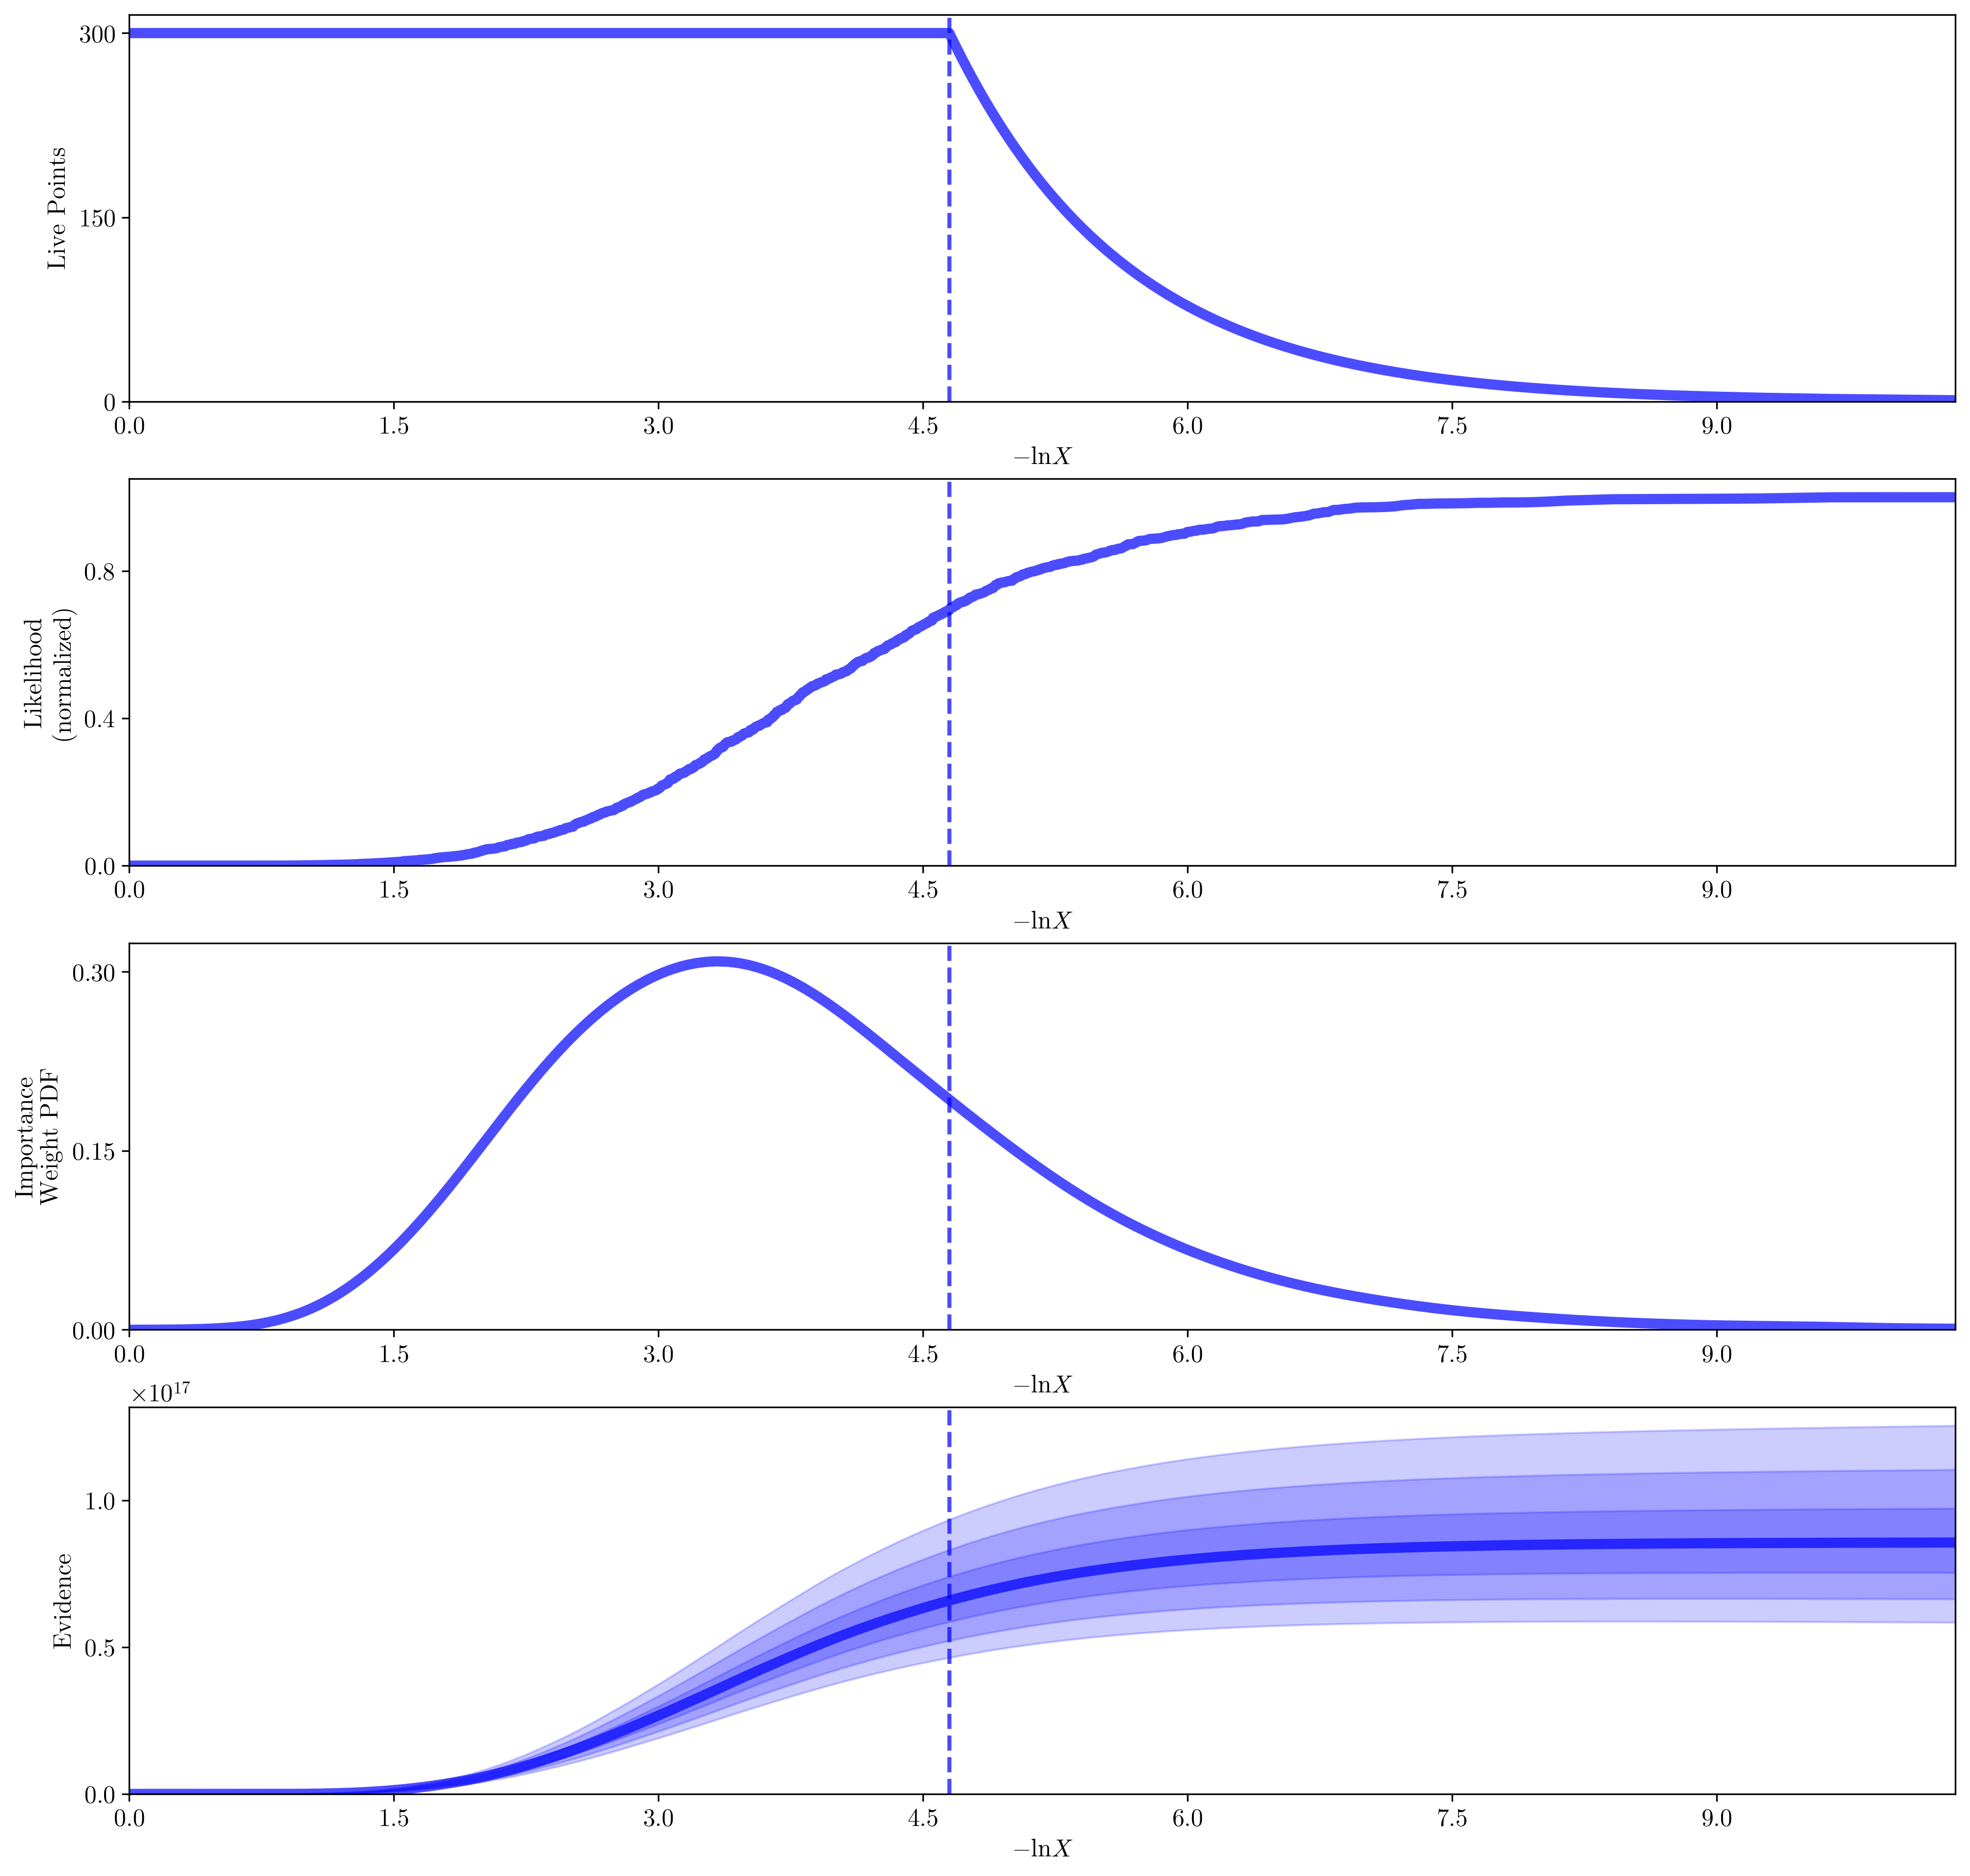

In [244]:
rfig, raxes = dyplot.runplot(results)

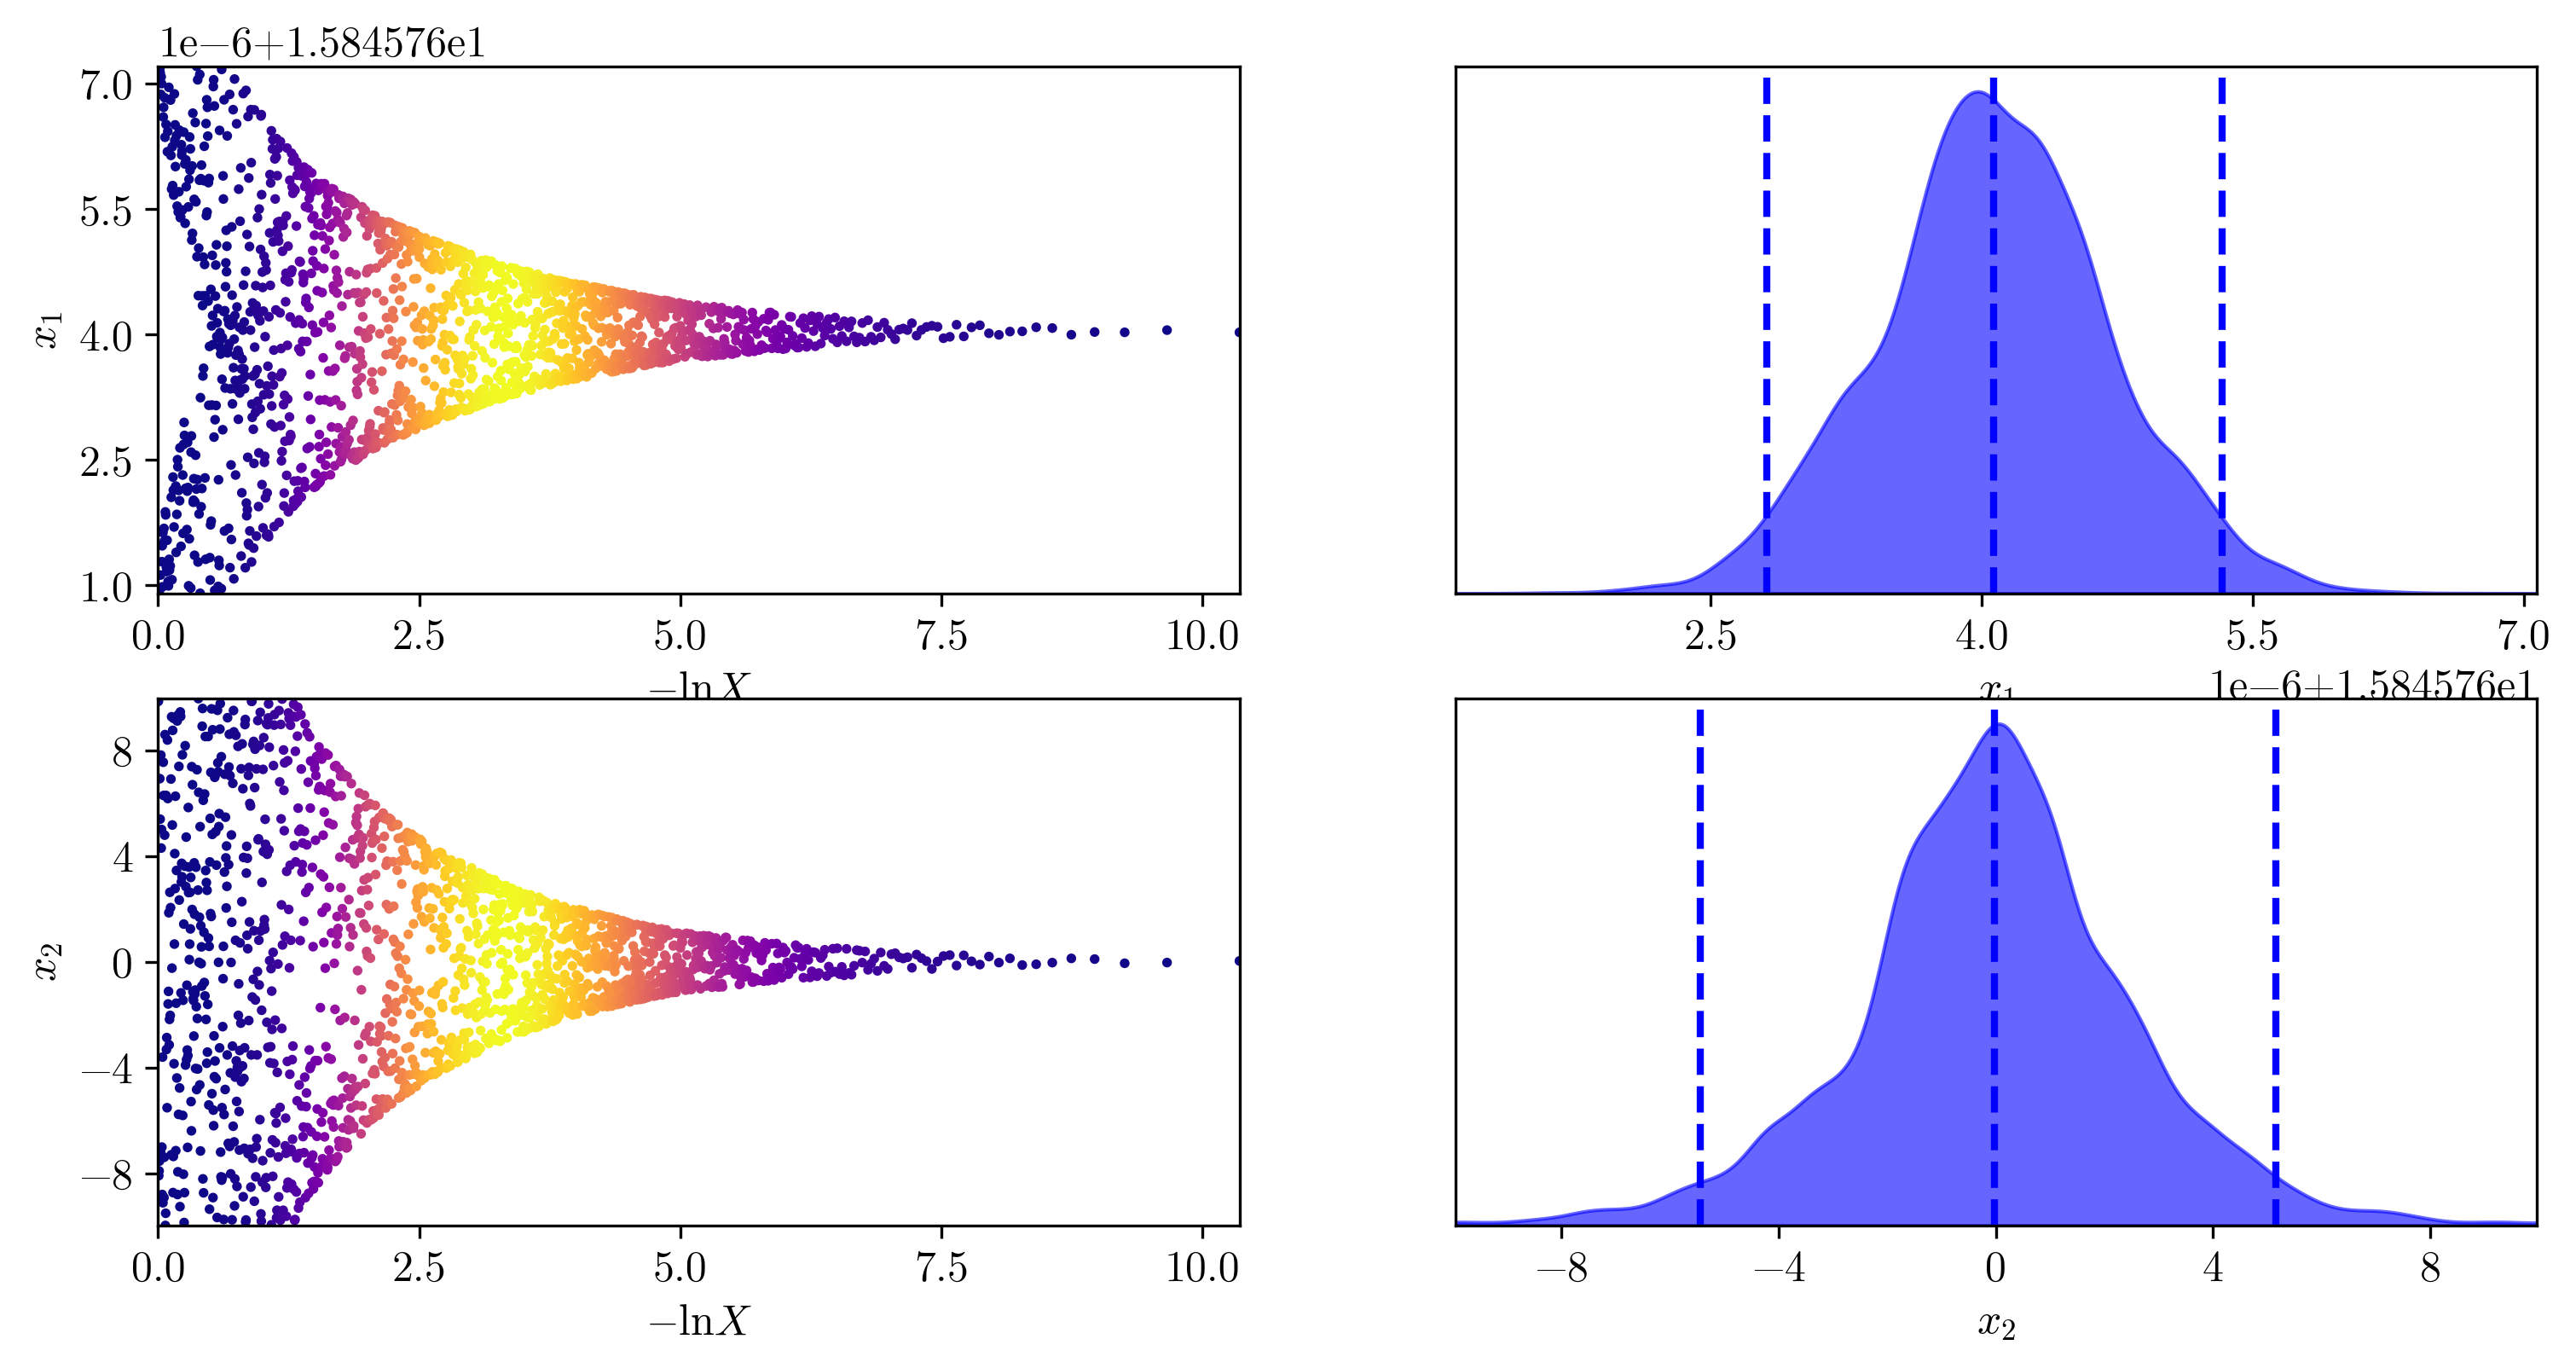

In [245]:
tfig, taxes = dyplot.traceplot(results)

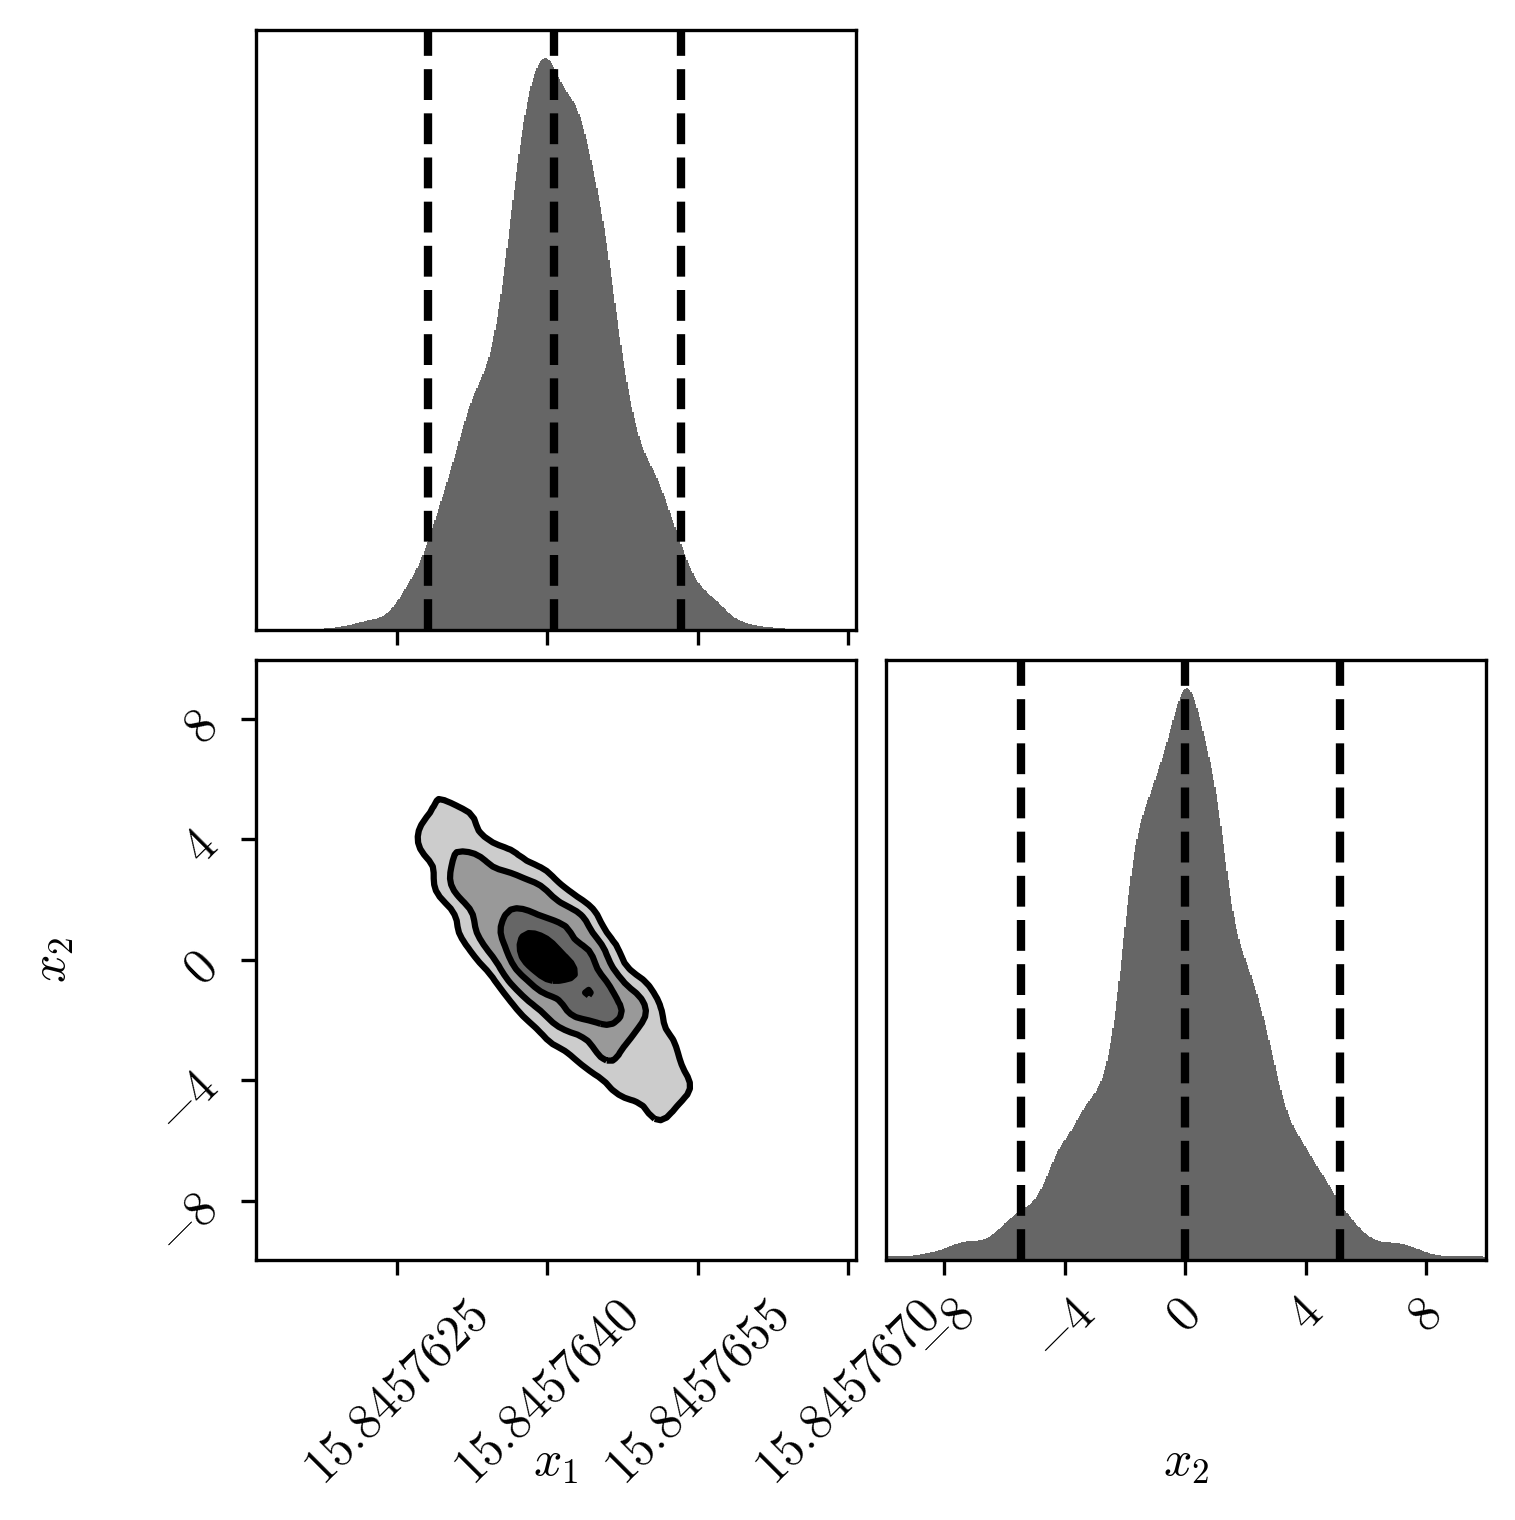

In [246]:
cfig, caxes = dyplot.cornerplot(results)

Check the likelihood directly

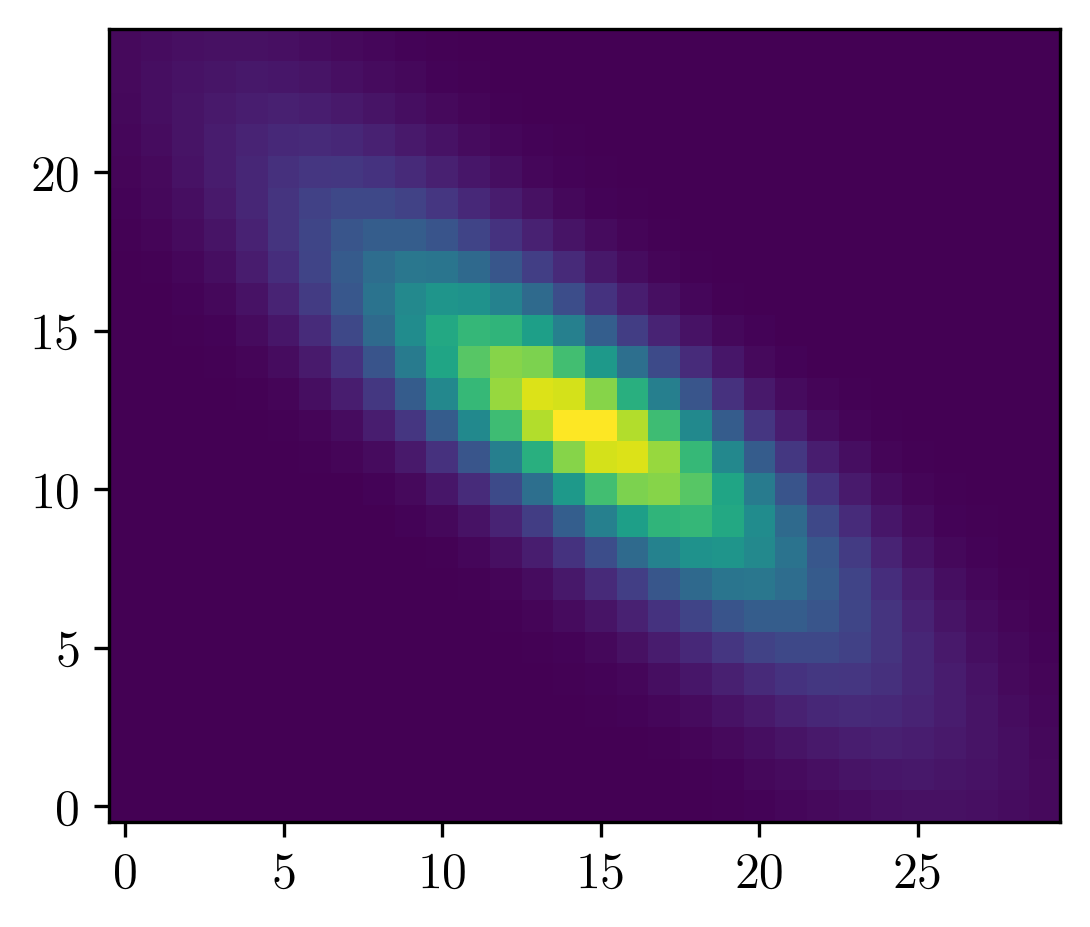

In [184]:
M_chirps = jnp.linspace(vb_s.M_chirp * (1 - 1e-7), vb_s.M_chirp * (1 + 1e-7), 30)
tT_cs = jnp.linspace(-6, 6, 25)
M_chirp_mg, tT_c_mg = jnp.meshgrid(M_chirps, tT_cs)
logLs = jax.vmap(logL_dynesty)(
    jnp.stack((M_chirp_mg, tT_c_mg), axis=-1).reshape(-1, 2)
).reshape(M_chirp_mg.shape)

plt.imshow(jnp.exp(logLs), origin="lower")

#### Dynamic dress

In [5]:
import dynesty
from dynesty import plotting as dyplot

In [94]:
m_1 = jnp.array(1e3 * MSUN)
m_2 = jnp.array(1 * MSUN)
rho_s = jnp.array(226 * MSUN / PC**3)
gamma_s = jnp.array(7 / 3)
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)
dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)


@jax.jit
def logL_dynesty(x):
    gamma_s, c_f, M_chirp_MSUN, tT_c = x
    dd_h = DynamicDress(
        gamma_s,
        c_f,
        M_chirp_MSUN * MSUN,
        dd_s.q,  # fixed
        dd_s.Phi_c,  # fixed
        tT_c,
        dL_iota=dd_s.dL_iota  # value doesn't matter
    )
    f_c_h = get_f_isco(get_m_1(dd_h.M_chirp, dd_h.q))
    return loglikelihood(dd_h, f_c_h, "d", dd_s, f_c, "d", f_l, f_c)

In [99]:
logL_dynesty(jnp.array([dd_s.gamma_s, dd_s.c_f, dd_s.M_chirp / MSUN, dd_s.tT_c]))

Buffer(42.2626203, dtype=float64)

In [100]:
logL_dynesty(jnp.array([dd_s.gamma_s, dd_s.c_f, dd_s.M_chirp / MSUN, dd_s.tT_c]))

Buffer(42.2626203, dtype=float64)

In [179]:
r_gamma_s = 1e-1
r_c_f = 2e-1
r_M_chirp_MSUN = 1e-4
d_tT_c = 120

labels = (
    r"$\gamma_s$",
    r"$c_f$ [?]",
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\tilde{t}_c$ [s]"
)

def ptform(u):
    return jnp.array([
        dd_s.gamma_s * (1 + r_gamma_s * (2 * u[0] - 1)),
        dd_s.c_f * (1 + r_c_f * (2 * u[1] - 1)),
        dd_s.M_chirp / MSUN * (1 + r_M_chirp_MSUN * (2 * u[2] - 1)),
        d_tT_c * (2 * u[3] - 1)
    ])

Run sampler

In [180]:
sampler = dynesty.NestedSampler(
    logL_dynesty, ptform, len(labels), nlive=1000, bound="multi"
)
sampler.run_nested()
results = sampler.results

5431it [22:01,  4.11it/s, bound: 84 | nc: 34 | ncall: 166564 | eff(%):  3.261 | loglstar:   -inf <  0.626 <    inf | logz:  0.105 +/-  0.004 | dlogz: 20.573 >  1.009] 


KeyboardInterrupt: 

In [182]:
results.summary()

Summary
nlive: 2000
niter: 1600
ncall: 4447
eff(%): 80.953
logz:  0.117 +/-  0.024


In [ ]:
rfig, raxes = dyplot.runplot(results)
rfig.tight_layout()

In [ ]:
tfig, taxes = dyplot.traceplot(results, labels=labels)
tfig.tight_layout()

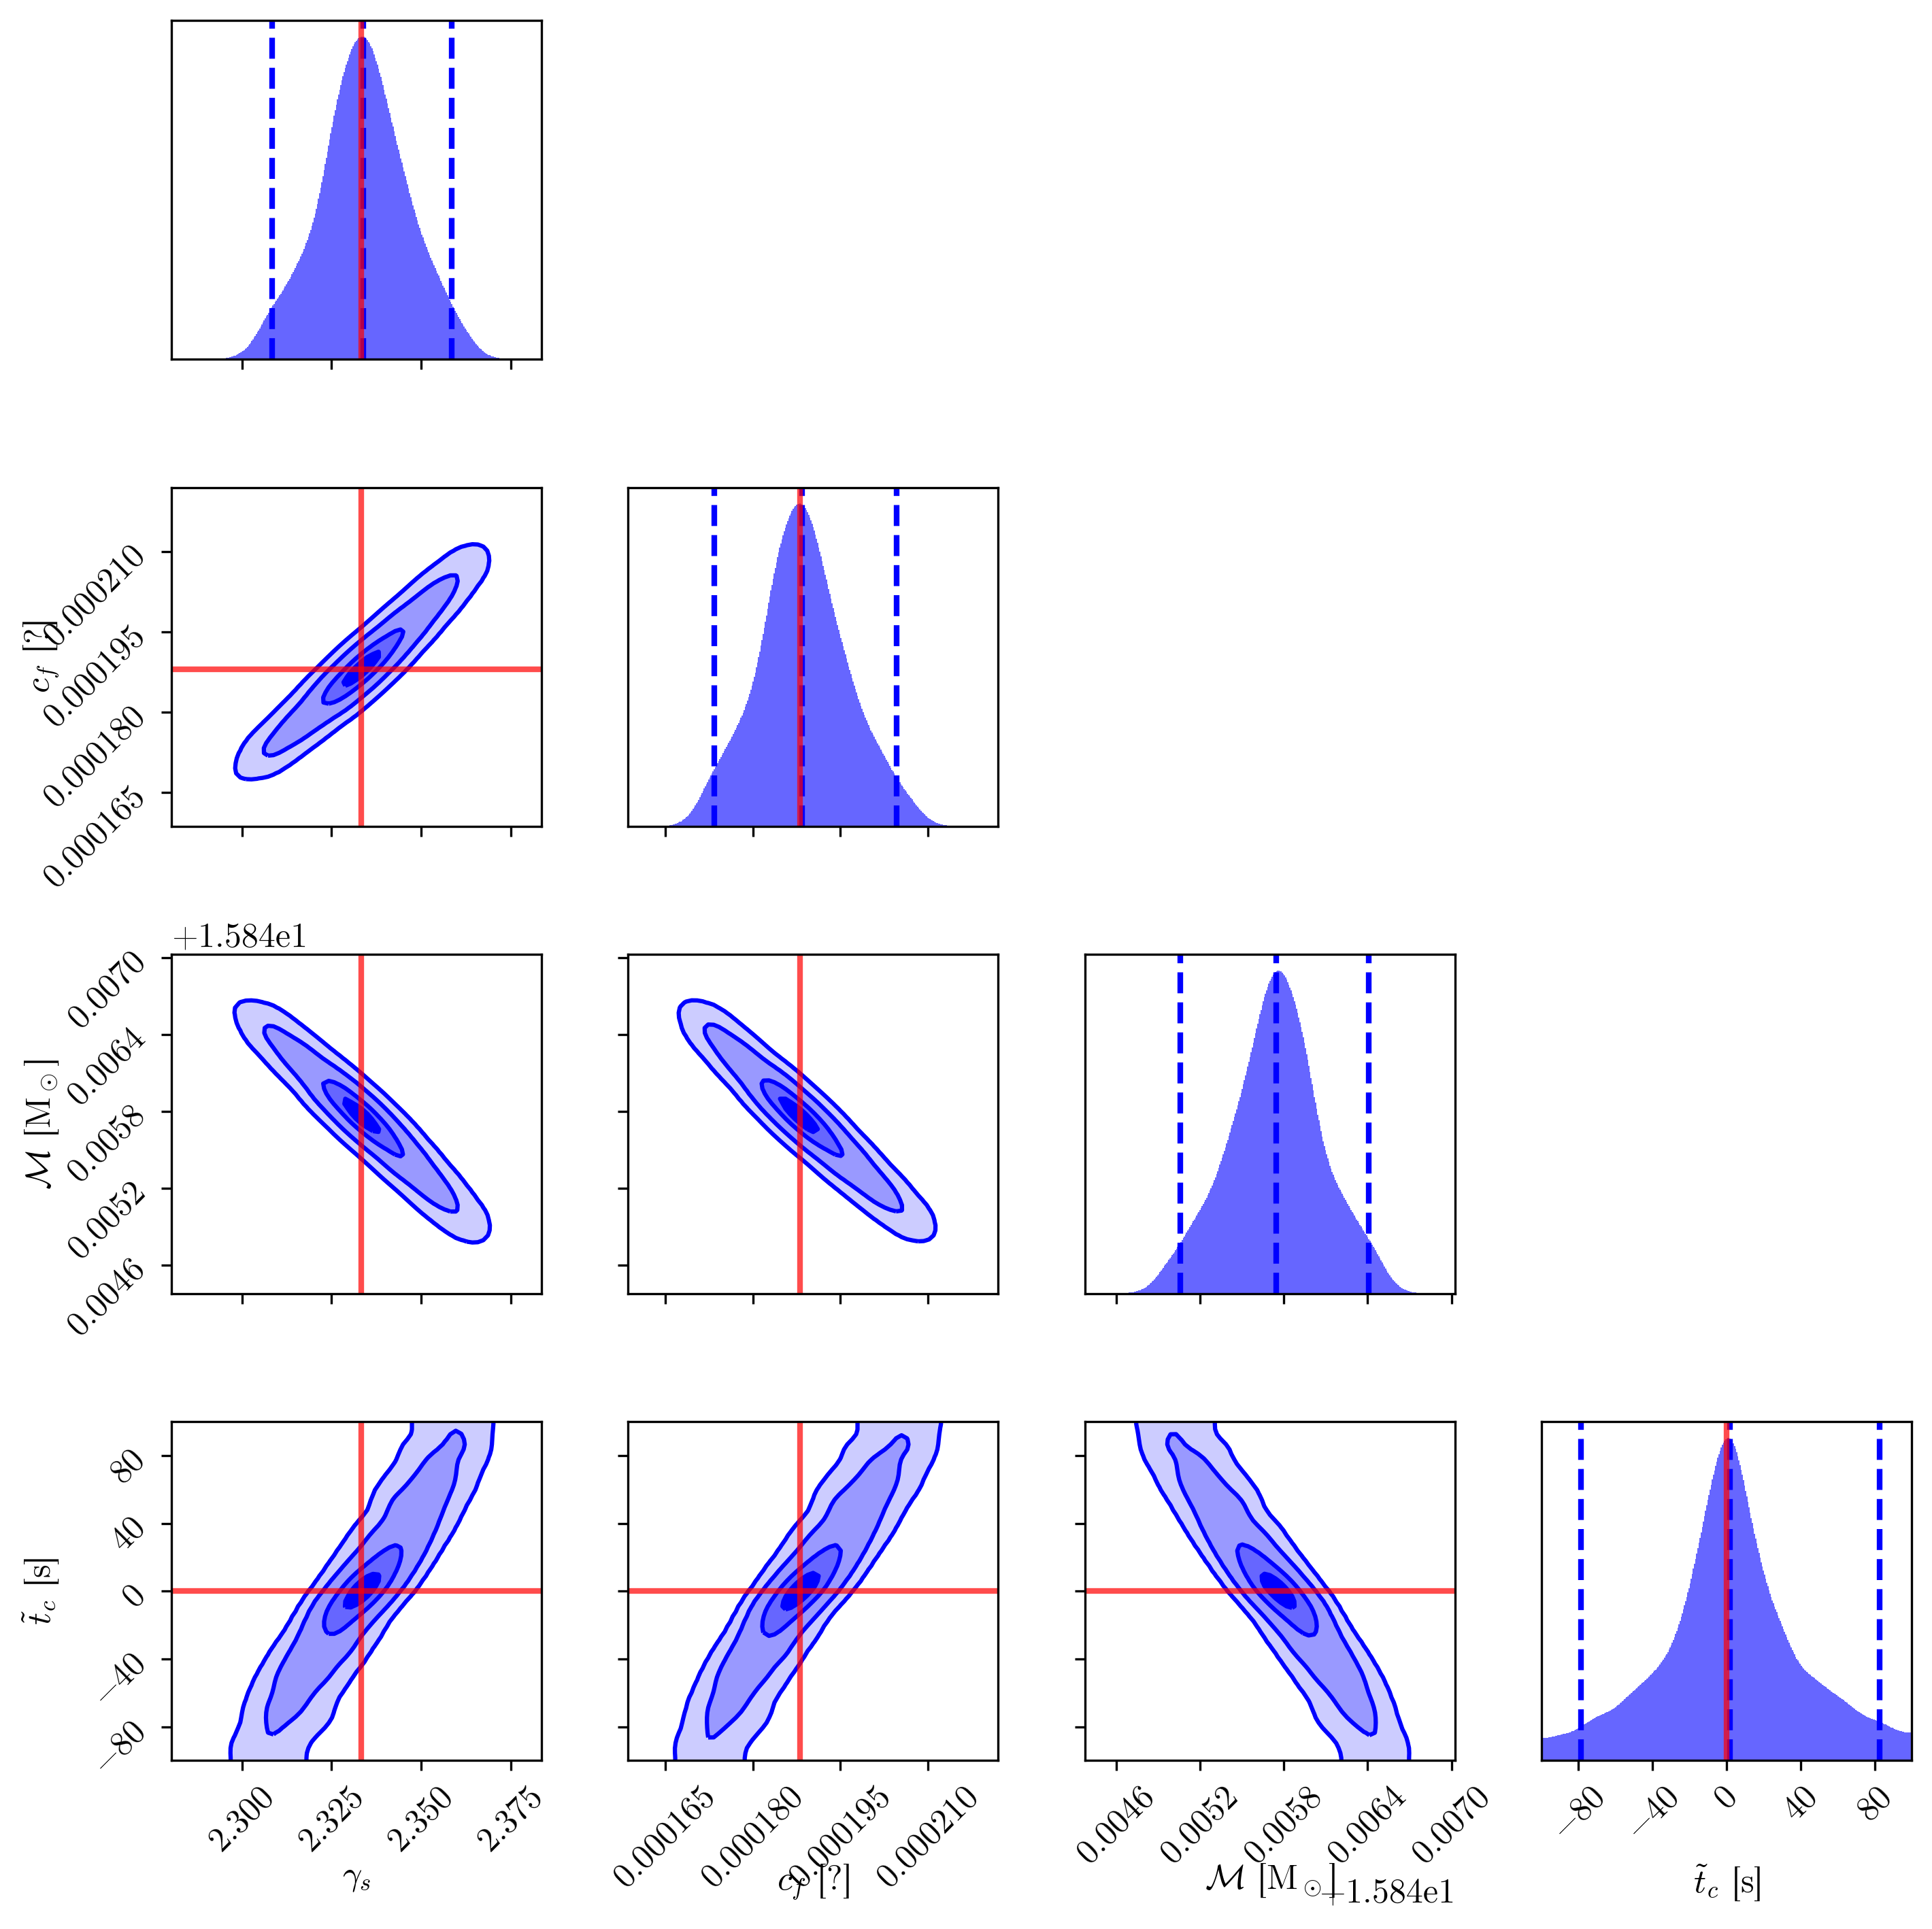

In [157]:
cfig, caxes = dyplot.cornerplot(
    results,
    labels=labels,
    quantiles_2d=[1 - np.exp(-x ** 2 / 2) for x in [0.5, 1, 2, 3]],
    smooth=0.03,
    cmap="viridis",
    truths=(dd_s.gamma_s, dd_s.c_f, dd_s.M_chirp, dd_s.tT_c),
    kde=False
)
cfig.tight_layout()

Plot actual likelihood

In [61]:
import numpy as np
from corner import corner


gamma_ss = jnp.linspace(
    dd_s.gamma_s * (1 - 5e-4),
    dd_s.gamma_s * (1 + 5e-4),
    4
)
M_chirp_MSUNs = jnp.linspace(
    dd_s.M_chirp / MSUN * (1 - 1e-7),
    dd_s.M_chirp / MSUN * (1 + 1e-7),
    5
)
tT_cs = jnp.linspace(-10, 10, 6)

logLs = np.zeros((len(gamma_ss), len(M_chirp_MSUNs), len(tT_cs)))
for i in range(logLs.shape[0]):
    for j in range(logLs.shape[1]):
        for k in range(logLs.shape[2]):
            logLs[i, j, k] = logL_dynesty(
                jnp.array([gamma_ss[i], M_chirp_MSUNs[j], tT_cs[k]])
            )

In [67]:
n_samples = 25000
xs = ptform(np.random.rand(3, n_samples)).T
logLs = jnp.stack([logL_dynesty(x) for x in xs])
weights = jnp.exp(logLs)

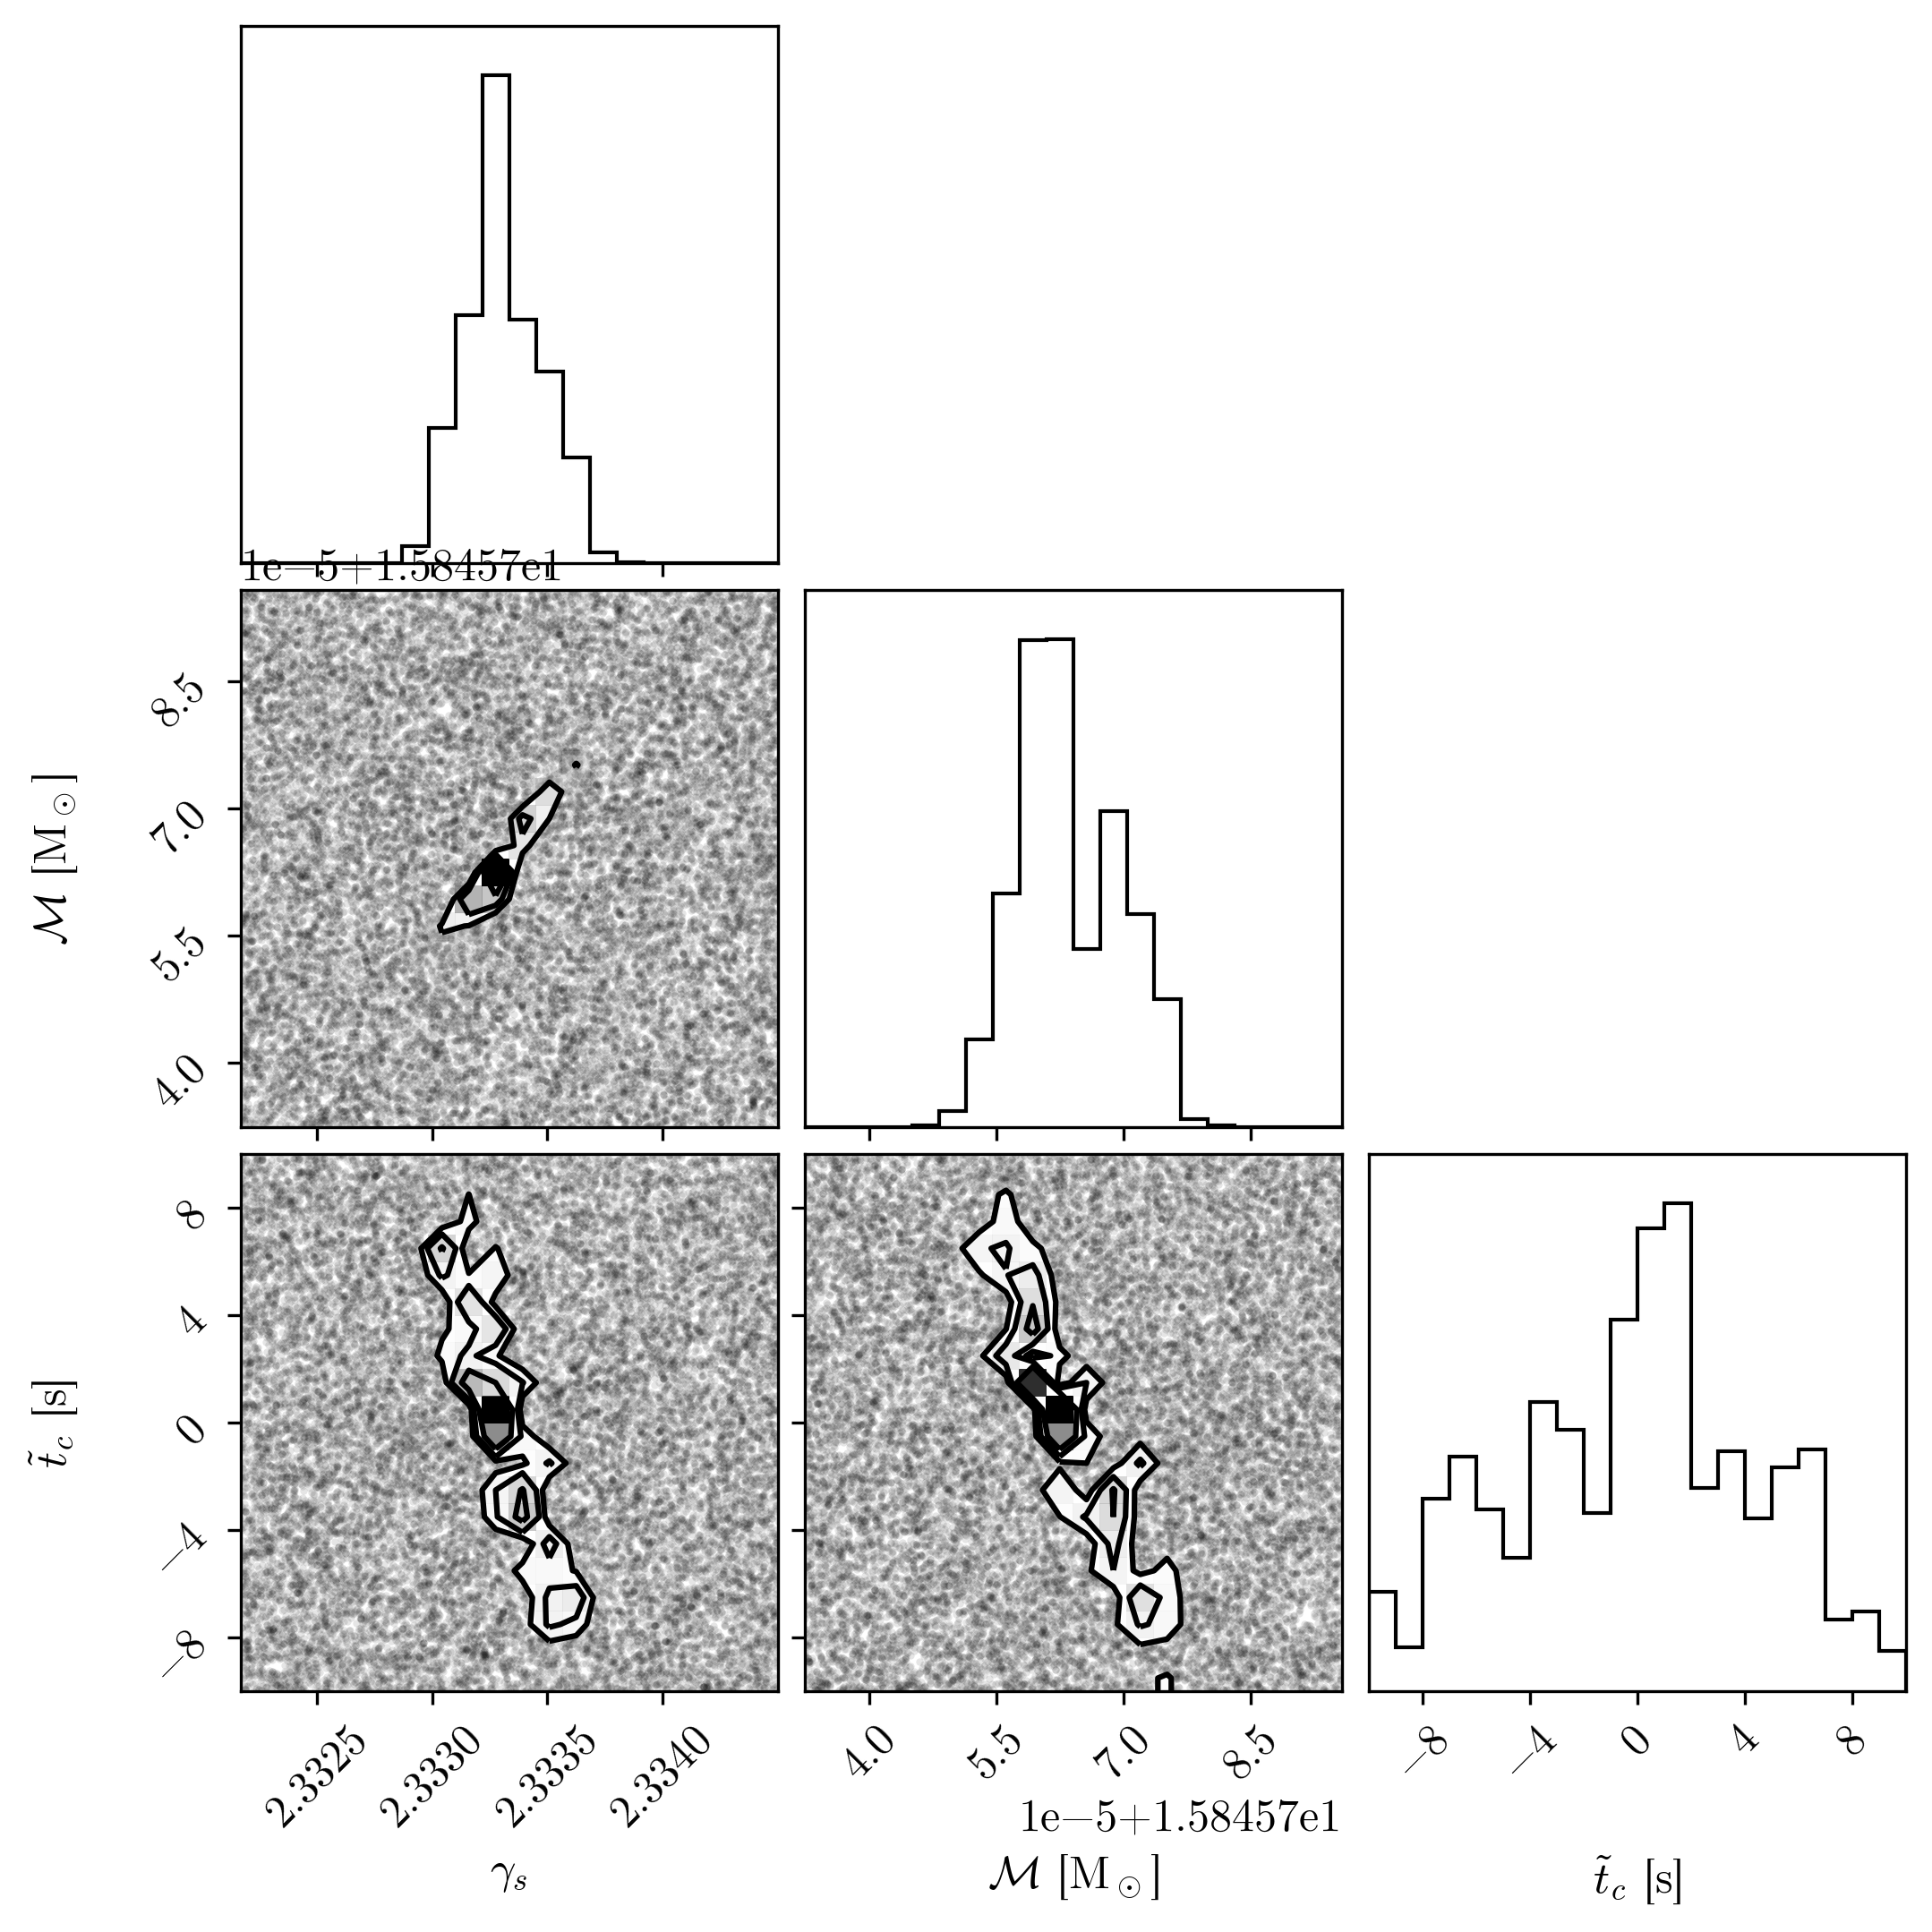

In [68]:
corner(
    np.array(xs),
    labels=(r"$\gamma_s$", r"$\mathcal{M}$ [M$_\odot$]", r"$\tilde{t}_c$ [s]"),
    weights=np.array(weights)
);

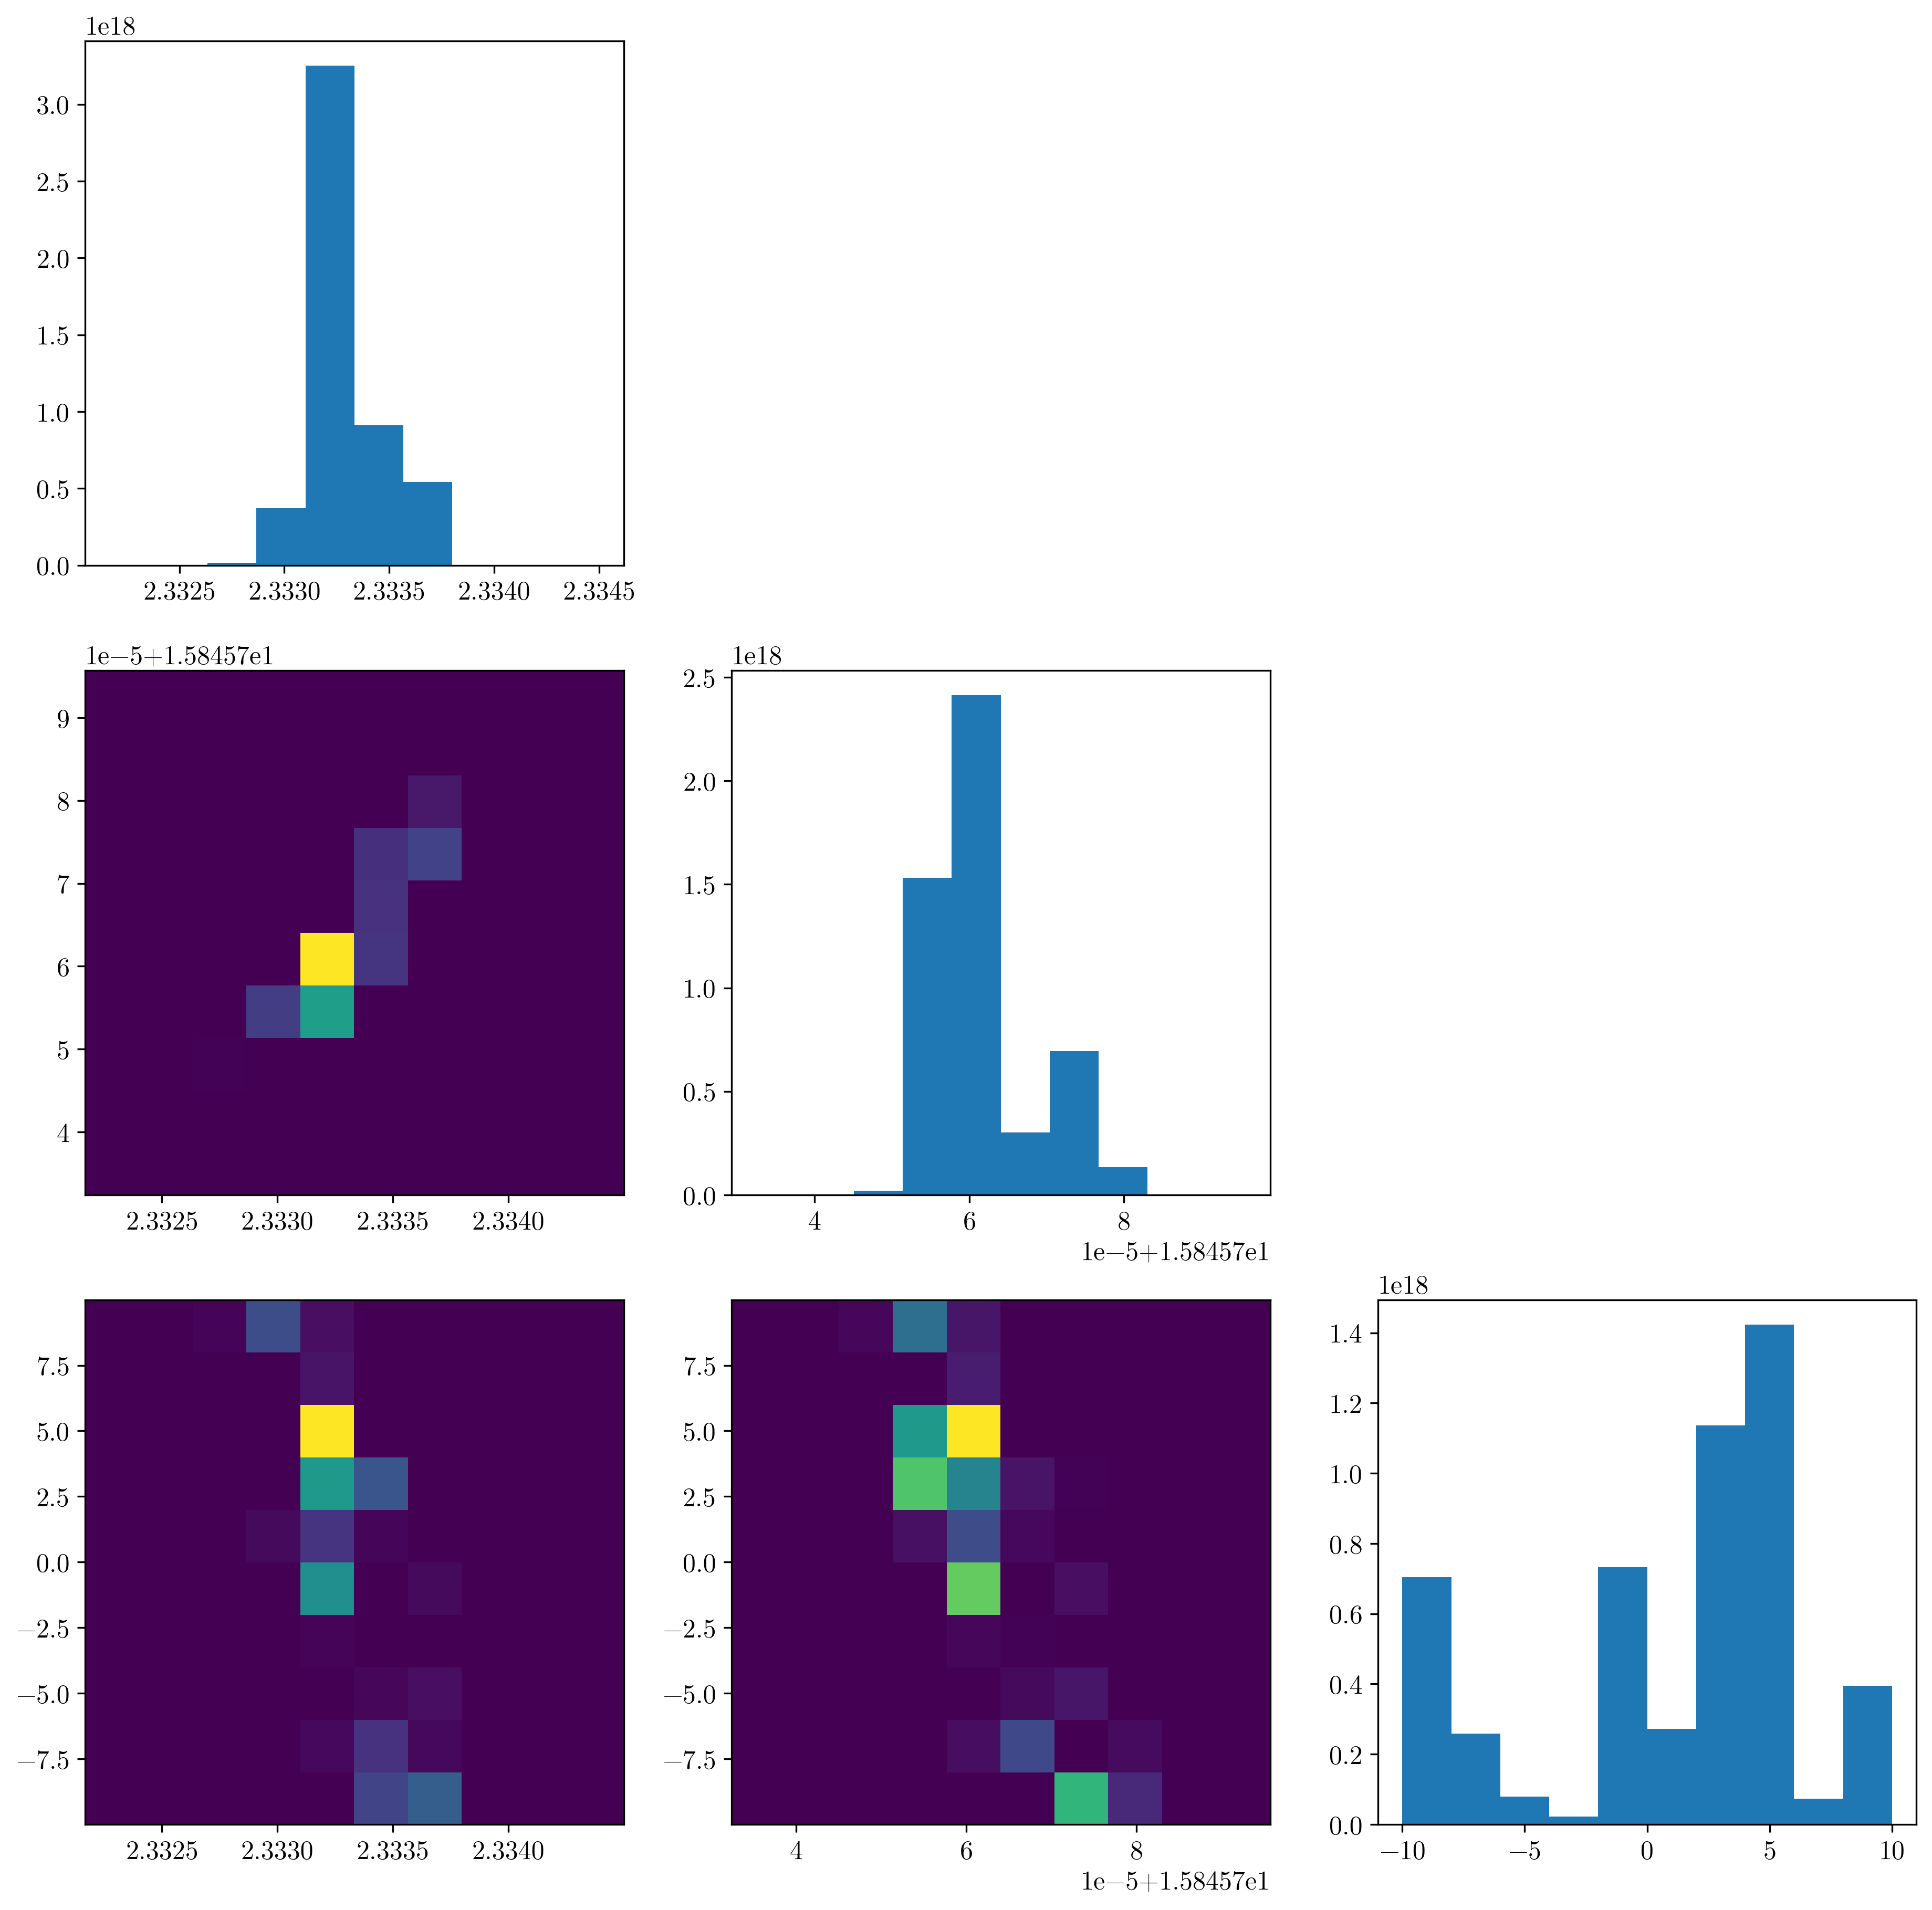

In [65]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        if i == j:
            ax.hist(xs[:, i], weights=weights)
        elif j < i:
            ax.hist2d(xs[:, j], xs[:, i], weights=weights)
        else:
            ax.axis("off")

## Testing `hyp2f1` interpolation

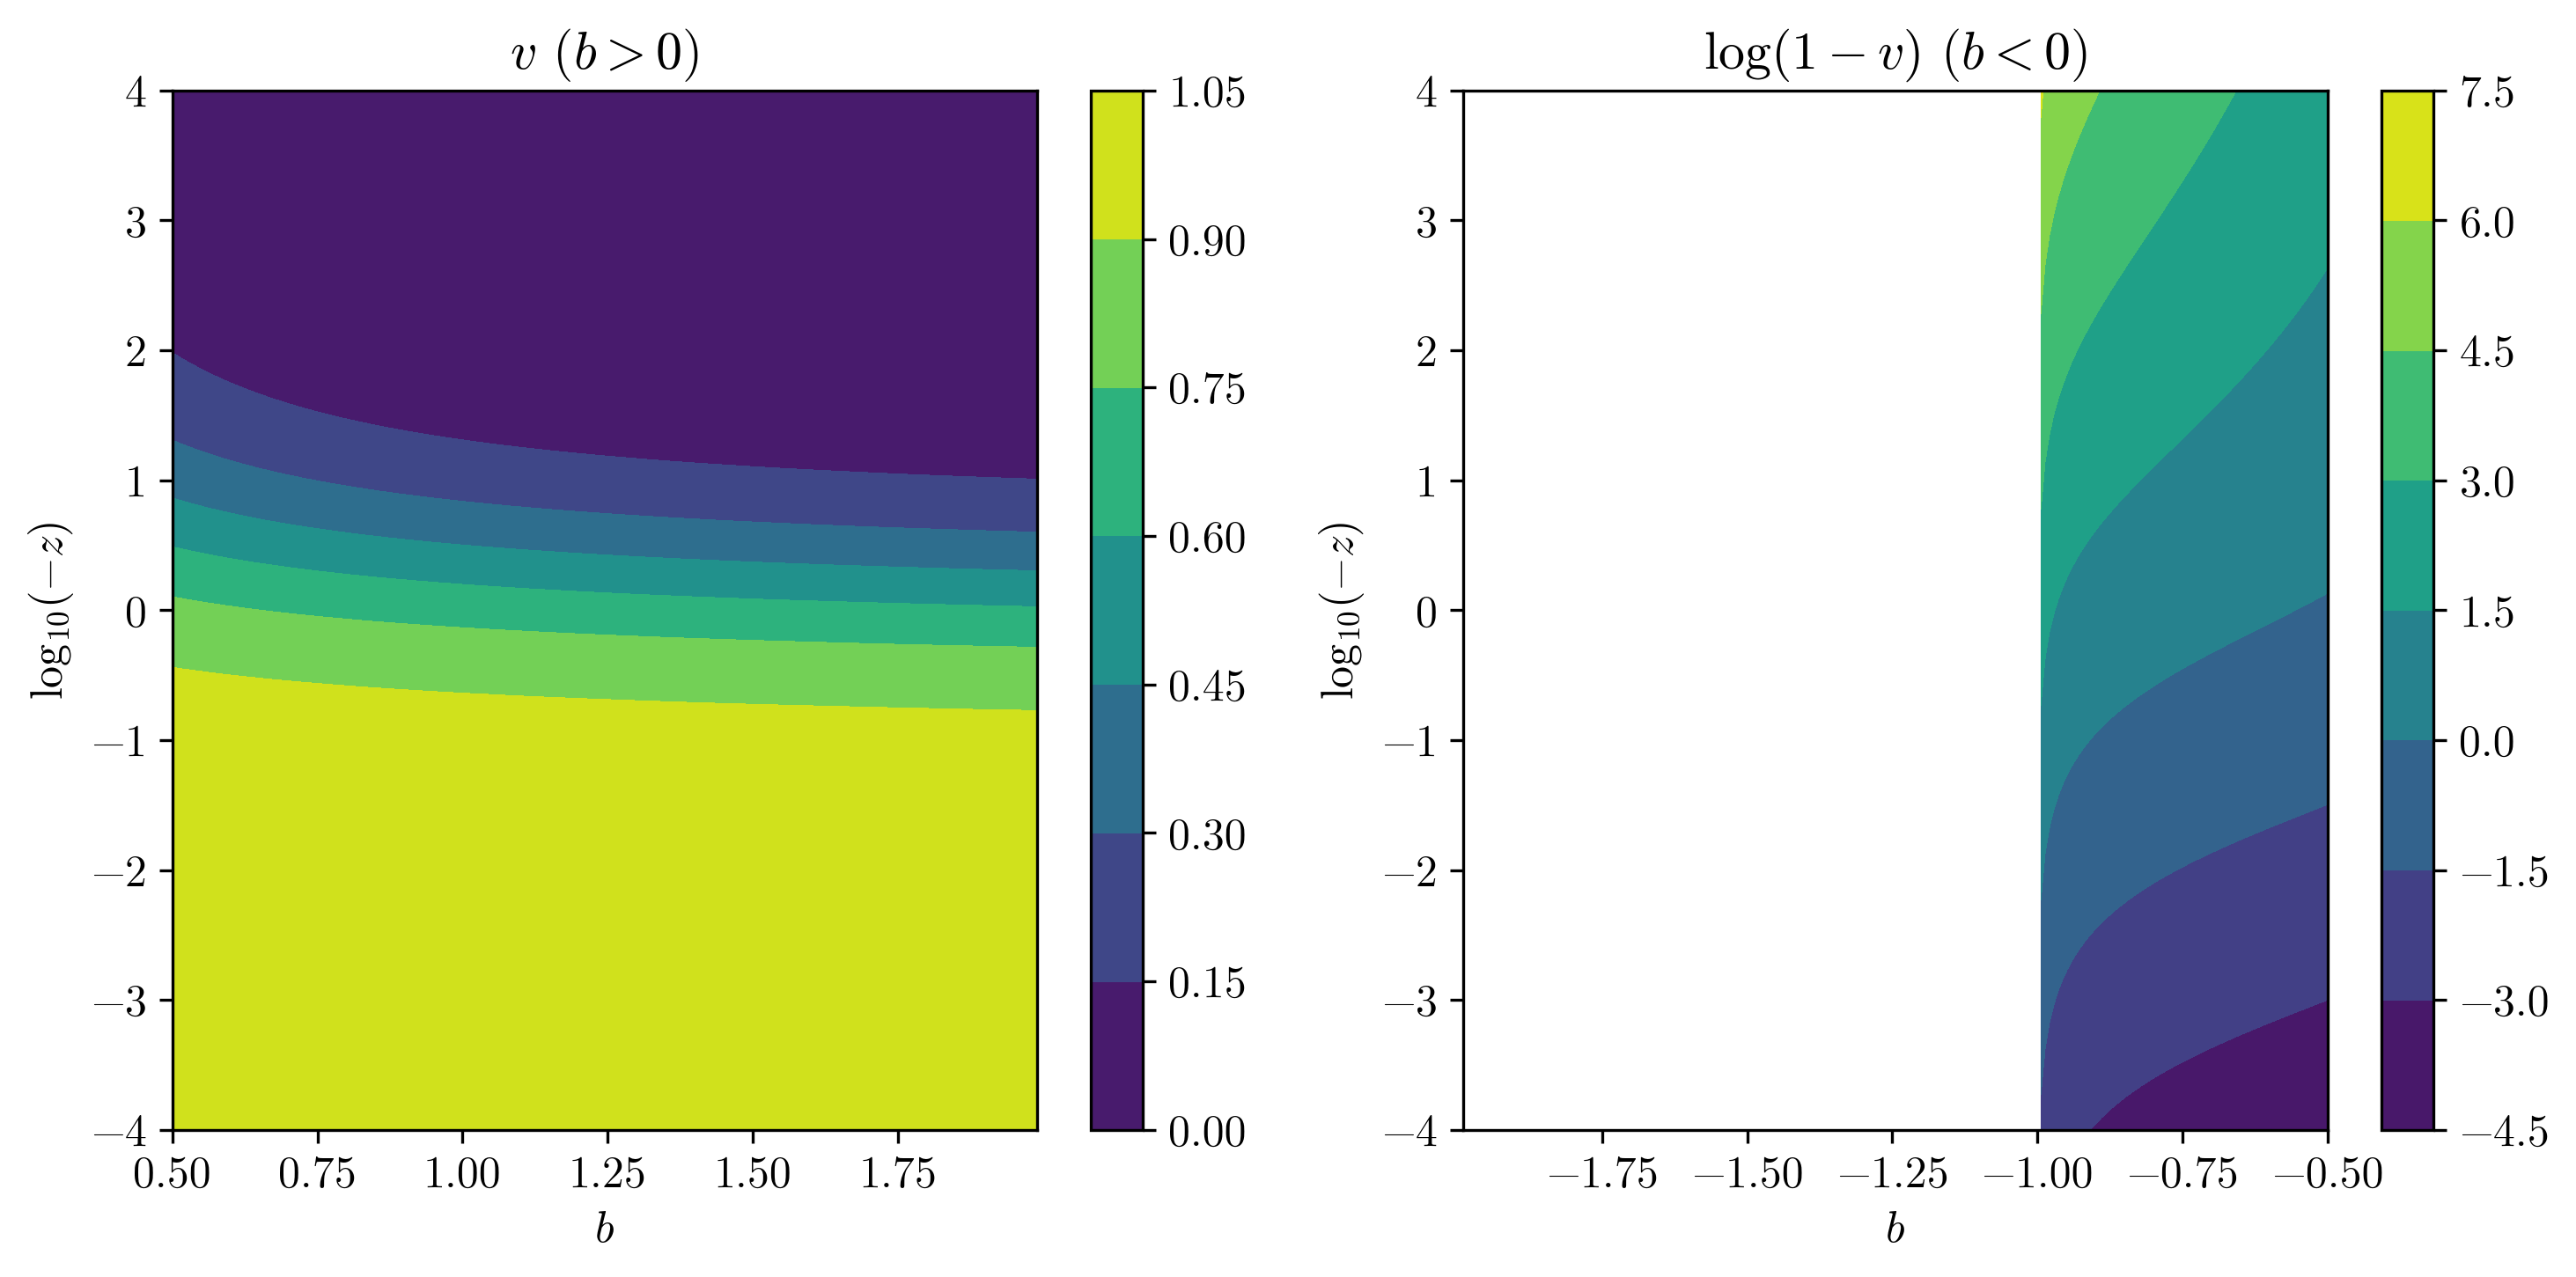

In [19]:
def plot_hypgeom():
    plt.figure(figsize=(10, 5))

    bs = jnp.linspace(0.5, 1.99, 200)  # +/-
    log10_abs_zs = jnp.linspace(-4, 4, 180)
    b_mg, log10_abs_z_mg = jnp.meshgrid(bs, log10_abs_zs, indexing="ij")
    vals = hypgeom_scipy(b_mg, -10**log10_abs_z_mg)
    plt.subplot(1, 2, 1)
    plt.contourf(b_mg, log10_abs_z_mg, vals)
    plt.colorbar()
    plt.xlabel(r"$b$")
    plt.ylabel(r"$\log_{10}(-z)$")
    plt.title(r"$v$ ($b > 0$)")

    bs = -jnp.linspace(0.5, 1.99, 200)  # +/-
    log10_abs_zs = jnp.linspace(-4, 4, 180)
    b_mg, log10_abs_z_mg = jnp.meshgrid(bs, log10_abs_zs, indexing="ij")
    vals = hypgeom_scipy(b_mg, -10**log10_abs_z_mg)
    plt.subplot(1, 2, 2)
    plt.contourf(b_mg, log10_abs_z_mg, jnp.log10(-1 + vals))
    plt.colorbar()
    plt.xlabel(r"$b$")
    plt.ylabel(r"$\log_{10}(-z)$")
    plt.title(r"$\log(1 - v)$ ($b < 0$)")

    plt.tight_layout()


plot_hypgeom()